In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

In [3]:
bird = 'B1425'
d = 512

In [4]:
#ratings = [1,2,3]
#ratings_str = ''.join([str(x) for x in ratings])

In [5]:
#sort_path =  '/mnt/cube/srrudrar/sorted/B1596/block4/continuous/Rhythm_FPGA-100.0/'#
#
#clusters = []
#for rating in ratings:
#    x = tu.get_clusters_by_rating(sort_path, rating)
#    clusters.extend(x)
#
#n_cells = len(clusters)

In [6]:
#np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1596.npy',clusters)

### Load dsets

In [7]:
stim_spec = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}.npy'.format(bird,d,d)) ###change
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d))###change

In [8]:
np.shape(stim_spec), np.shape(stim_resp)

((10857, 512), (10857, 125, 32))

In [9]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [10]:
nsegbins = 32

In [11]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [12]:
np.shape(stim_mne), np.shape(resp_mne)

((10857, 512), (10857, 125))

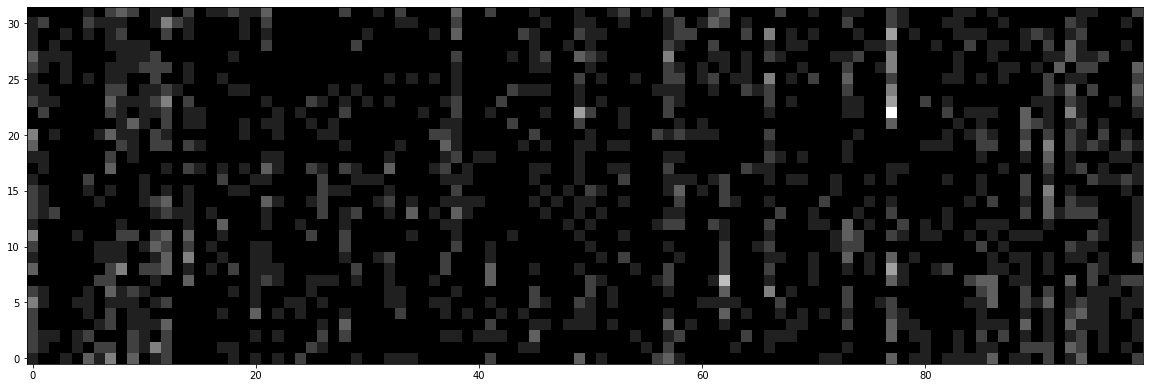

In [13]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [14]:
len_units = np.shape(resp_mne)[1]

In [15]:
units_to_process1 = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_{}_block6.npy'.format(bird)))        ###change

In [16]:
import random
units_to_process = random.sample(units_to_process1, 50)

In [17]:
np.min(units_to_process)

1

In [18]:
exp_path = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/'.format(bird,d)       ###change

In [19]:
shuffled_inds = []
n_train_list = []

In [20]:
# obtain all preprocessed datas

%matplotlib inline
sdim = d                                                                                                          ###change                                                                
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test, shuffled_idxs, n_train = MNE.prepare_MNE_train_test_set(stim_mne, 
                                                                                                     resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    shuffled_inds.append(shuffled_idxs)
    n_train_list.append(n_train)
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678382
    2       0    0.676477
    3       0    0.676361
    4       0    0.675612
    5       0    0.674858
    6       0    0.674666
    7       0    0.674467
    8       0    0.674657
    9       1    0.674671
   10       2    0.674382
   11       0    0.674179
   12       0    0.674159
   13       0    0.674229
   14       1    0.674149
   15       0    0.674013
   16       0    0.673906
   17       0    0.673789
   18       0    0.673746
   19       0    0.673892
   20       1    0.673862
   21       2    0.673869
   22       3    0.673965
   23       4    0.674111
   24       5    0.673853
   25       6    0.673623
   26       0    0.673676
   27       1    0.673952
   28       2    0.673926
   29       3    0.673722
   30       4    0.673701
   31       5    0.674018
   32       6    0.674097
   33       7    0.674033
   34       8    0.673999
   35       9    0.674126
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.680238
    2       0    0.677472
    3       0    0.677044
    4       0    0.676515
    5       0    0.676876
    6       1    0.676419
    7       0    0.675192
    8       0    0.675098
    9       0    0.674389
   10       0    0.674186
   11       0    0.674371
   12       1    0.674140
   13       0    0.674364
   14       1    0.674277
   15       2    0.673865
   16       0    0.673764
   17       0    0.673958
   18       1    0.673882
   19       2    0.673967
   20       3    0.674156
   21       4    0.673579
   22       0    0.673635
   23       1    0.673811
   24       2    0.673769
   25       3    0.673700
   26       4    0.673764
   27       5    0.673668
   28       6    0.673622
   29       7    0.673718
   30       8    0.673747
   31       9    0.673667
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.679528
    2       0    0.675955
    3       0    0.675537
    4       0    0.675001
    5       0    0.675385
    6       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678467
    2       0    0.676390
    3       0    0.675739
    4       0    0.673939
    5       0    0.674127
    6       1    0.673324
    7       0    0.672889
    8       0    0.672934
    9       1    0.672402
   10       0    0.672704
   11       1    0.672386
   12       0    0.672093
   13       0    0.672363
   14       1    0.672002
   15       0    0.671862
   16       0    0.671966
   17       1    0.671857
   18       0    0.671917
   19       1    0.672198
   20       2    0.671969
   21       3    0.671750
   22       0    0.672135
   23       1    0.672093
   24       2    0.672159
   25       3    0.672340
   26       4    0.672376
   27       5    0.672645
   28       6    0.672370
   29       7    0.672523
   30       8    0.672718
   31       9    0.672628
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.113267
    2       0    0.116765
    3       0    0.116268
    4       0    0.118645
    5       1    0.119439
    6       2    0.118853
    7       3    0.120562
    8       4    0.117546
    9       5    0.114537
   10       0    0.113910
   11       0    0.114758
   12       1    0.115330
   13       2    0.116941
   14       3    0.117114
   15       4    0.116037
   16       5    0.117222
   17       6    0.119227
   18       7    0.125576
   19       8    0.129494
   20       9    0.130942
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.111677
    2       0    0.110141
    3       0    0.114784
    4       1    0.117608
    5       2    0.117464
    6       3    0.116430
    7       4    0.115669
    8       5    0.117122
    9       6    0.116867
   10       7    0.115037
   11       8    0.116960
   12       9    0.120048
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109909
    2       0    0.115678
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.030150
    2       0    0.029659
    3       0    0.026367
    4       0    0.027293
    5       1    0.028815
    6       2    0.029174
    7       3    0.029100
    8       4    0.032498
    9       5    0.040380
   10       6    0.043919
   11       7    0.042031
   12       8    0.048969
   13       9    0.056679
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.025586
    2       0    0.025484
    3       0    0.023761
    4       0    0.023800
    5       1    0.022745
    6       0    0.021252
    7       0    0.023060
    8       1    0.023488
    9       2    0.024700
   10       3    0.024961
   11       4    0.026854
   12       5    0.028355
   13       6    0.030657
   14       7    0.031337
   15       8    0.033618
   16       9    0.034117
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.030765
    2       0    0.028022
    3       0    0.025325
    4       0    0.025307
    5       0    0.027756
    6       1    0.034686
    7       2    0.038498
    8       3    0.039198
    9       4    0.037967
   10       5    0.038068
   11       6    0.039341
   12       7    0.041540
   13       8    0.045106
   14       9    0.045968
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.034256
    2       0    0.033138
    3       0    0.032297
    4       0    0.032787
    5       1    0.035072
    6       2    0.038678
    7       3    0.048975
    8       4    0.049643
    9       5    0.058705
   10       6    0.060144
   11       7    0.065506
   12       8    0.062243
   13       9    0.062104
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.670942
    2       0    0.670910
    3       0    0.670753
    4       0    0.669249
    5       0    0.668689
    6       0    0.667873
    7       0    0.667511
    8       0    0.667737
    9       1    0.667663
   10       2    0.668103
   11       3    0.668071
   12       4    0.667467
   13       0    0.667320
   14       0    0.666975
   15       0    0.666814
   16       0    0.667122
   17       1    0.667329
   18       2    0.667067
   19       3    0.667031
   20       4    0.666845
   21       5    0.666818
   22       6    0.666787
   23       0    0.666722
   24       0    0.666983
   25       1    0.667071
   26       2    0.667223
   27       3    0.667238
   28       4    0.667146
   29       5    0.667118
   30       6    0.667245
   31       7    0.667361
   32       8    0.667278
   33       9    0.667262
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.674683
    2       0    0.671873
    3       0    0.670978
    4       0    0.671132
    5       1    0.670202
    6       0    0.669425
    7       0    0.669417
    8       0    0.669751
    9       1    0.669643
   10       2    0.669340
   11       0    0.669664
   12       1    0.669693
   13       2    0.669481
   14       3    0.670033
   15       4    0.670029
   16       5    0.669649
   17       6    0.669571
   18       7    0.669766
   19       8    0.669541
   20       9    0.669271
   21       0    0.669584
   22       1    0.669610
   23       2    0.669680
   24       3    0.670039
   25       4    0.669944
   26       5    0.670109
   27       6    0.670351
   28       7    0.670668
   29       8    0.670721
   30       9    0.670462
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.673948
    2       0    0.671019
    3       0    0.669349
    4       0    0.669219
    5       0    0.668966
    6       0    0.668683
    7       0    0.668484
    8       0    0.668130
    9       0    0.667918
   10       0    0.667995
   11       1    0.668001
   12       2    0.667497
   13       0    0.667411
   14       0    0.667425
   15       1    0.667606
   16       2    0.667507
   17       3    0.667393
   18       0    0.667404
   19       1    0.667666
   20       2    0.667589
   21       3    0.667661
   22       4    0.667872
   23       5    0.667902
   24       6    0.667974
   25       7    0.668064
   26       8    0.667999
   27       9    0.667958
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.675781
    2       0    0.673596
    3       0    0.672664
    4       0    0.671621
    5       0    0.671734
    6       1    0.670989
    7       0    0.670601
    8       0    0.670024
    9       0    0.671101
   10       1    0.670478
   11       2    0.670653
   12       3    0.670901
   13       4    0.671699
   14       5    0.670935
   15       6    0.670718
   16       7    0.671122
   17       8    0.670406
   18       9    0.670454
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.708086
    2       0    0.705708
    3       0    0.704163
    4       0    0.704547
    5       1    0.703504
    6       0    0.702518
    7       0    0.702766
    8       1    0.702150
    9       0    0.702254
   10       1    0.702061
   11       0    0.701825
   12       0    0.702031
   13       1    0.702410
   14       2    0.701895
   15       3    0.702127
   16       4    0.702196
   17       5    0.701481
   18       0    0.701401
   19       0    0.701183
   20       0    0.701458
   21       1    0.701709
   22       2    0.701650
   23       3    0.701438
   24       4    0.701501
   25       5    0.701132
   26       0    0.701023
   27       0    0.701196
   28       1    0.701389
   29       2    0.701200
   30       3    0.701267
   31       4    0.701356
   32       5    0.701215
   33       6    0.701391
   34       7    0.701280
   35       8    0.701431
   36       9    0.701509
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.708502
    2       0    0.705244
    3       0    0.704221
    4       0    0.702643
    5       0    0.701036
    6       0    0.700977
    7       0    0.701201
    8       1    0.700514
    9       0    0.700166
   10       0    0.700753
   11       1    0.699472
   12       0    0.698965
   13       0    0.699388
   14       1    0.699531
   15       2    0.698991
   16       3    0.699168
   17       4    0.698705
   18       0    0.699204
   19       1    0.698985
   20       2    0.698168
   21       0    0.698159
   22       0    0.698463
   23       1    0.698404
   24       2    0.698149
   25       0    0.698471
   26       1    0.698922
   27       2    0.698637
   28       3    0.698706
   29       4    0.698931
   30       5    0.698945
   31       6    0.699061
   32       7    0.699568
   33       8    0.698703
   34       9    0.699254
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.708050
    2       0    0.705150
    3       0    0.703735
    4       0    0.703150
    5       0    0.702879
    6       0    0.701956
    7       0    0.701886
    8       0    0.701922
    9       1    0.702033
   10       2    0.700858
   11       0    0.700610
   12       0    0.700274
   13       0    0.700236
   14       0    0.700239
   15       1    0.699998
   16       0    0.699955
   17       0    0.700114
   18       1    0.699785
   19       0    0.699879
   20       1    0.700657
   21       2    0.701412
   22       3    0.701002
   23       4    0.700613
   24       5    0.700417
   25       6    0.700269
   26       7    0.700284
   27       8    0.700326
   28       9    0.700038
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.709963
    2       0    0.706302
    3       0    0.705473
    4       0    0.704100
    5       0    0.703175
    6       0    0.702344
    7       0    0.702034
    8       0    0.701918
    9       0    0.701508
   10       0    0.701754
   11       1    0.702406
   12       2    0.701453
   13       0    0.701230
   14       0    0.701053
   15       0    0.700872
   16       0    0.700834
   17       0    0.701185
   18       1    0.701413
   19       2    0.701236
   20       3    0.701161
   21       4    0.701060
   22       5    0.700936
   23       6    0.700828
   24       0    0.701054
   25       1    0.701261
   26       2    0.701340
   27       3    0.701626
   28       4    0.702060
   29       5    0.701960
   30       6    0.702232
   31       7    0.702630
   32       8    0.702703
   33       9    0.702544
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.363436
    2       0    0.362895
    3       0    0.360831
    4       0    0.360749
    5       0    0.360355
    6       0    0.360242
    7       0    0.359231
    8       0    0.358723
    9       0    0.358728
   10       1    0.358281
   11       0    0.358428
   12       1    0.359006
   13       2    0.357992
   14       0    0.358159
   15       1    0.358777
   16       2    0.359368
   17       3    0.358477
   18       4    0.359787
   19       5    0.359965
   20       6    0.359335
   21       7    0.359222
   22       8    0.359646
   23       9    0.359991
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.357505
    2       0    0.357406
    3       0    0.356907
    4       0    0.356070
    5       0    0.355830
    6       0    0.356146
    7       1    0.355145
    8       0    0.356169
    9       1    0.357448
   10       2    0.355986
   11       3    0.355378
   12       4    0.355449
   13       5    0.355239
   14       6    0.354970
   15       0    0.355350
   16       1    0.355258
   17       2    0.354457
   18       0    0.354857
   19       1    0.354732
   20       2    0.354882
   21       3    0.354851
   22       4    0.355827
   23       5    0.356681
   24       6    0.356055
   25       7    0.356420
   26       8    0.356956
   27       9    0.357317
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.351668
    2       0    0.351768
    3       0    0.350612
    4       0    0.349669
    5       0    0.349254
    6       0    0.349179
    7       0    0.350236
    8       1    0.348473
    9       0    0.348540
   10       1    0.348418
   11       0    0.348235
   12       0    0.348751
   13       1    0.349618
   14       2    0.349671
   15       3    0.349150
   16       4    0.349417
   17       5    0.348959
   18       6    0.348811
   19       7    0.349102
   20       8    0.349479
   21       9    0.349102
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.365689
    2       0    0.363624
    3       0    0.360563
    4       0    0.359715
    5       0    0.360191
    6       1    0.361426
    7       2    0.360514
    8       3    0.360337
    9       4    0.360641
   10       5    0.359405
   11       0    0.359226
   12       0    0.359043
   13       0    0.359022
   14       0    0.358908
   15       0    0.358712
   16       0    0.358698
   17       0    0.358748
   18       1    0.358972
   19       2    0.359353
   20       3    0.359438
   21       4    0.359598
   22       5    0.360182
   23       6    0.360867
   24       7    0.360404
   25       8    0.361250
   26       9    0.361426
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.545156
    2       0    0.543998
    3       0    0.543336
    4       0    0.541737
    5       0    0.539614
    6       0    0.539948
    7       1    0.540997
    8       2    0.541499
    9       3    0.540504
   10       4    0.542140
   11       5    0.542193
   12       6    0.541473
   13       7    0.541838
   14       8    0.541147
   15       9    0.540635
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.550977
    2       0    0.550008
    3       0    0.552790
    4       1    0.553989
    5       2    0.549205
    6       0    0.549737
    7       1    0.549713
    8       2    0.548850
    9       0    0.549735
   10       1    0.548831
   11       0    0.547699
   12       0    0.548221
   13       1    0.548590
   14       2    0.550684
   15       3    0.550113
   16       4    0.550686
   17       5    0.553002
   18       6    0.554880
   19       7    0.553594
   20       8    0.552461
   21       9    0.552883
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.539534
    2       0    0.540496
    3       0    0.535531
    4       0    0.537265
    5       1    0.534159
    6       0    0.533248
    7       0    0.534013
    8       1    0.533836
    9       2    0.533260
   10       3    0.534693
   11       4    0.534723
   12       5    0.533782
   13       6    0.534560
   14       7    0.534645
   15       8    0.535475
   16       9    0.536416
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.546270
    2       0    0.546689
    3       0    0.543941
    4       0    0.544644
    5       1    0.541495
    6       0    0.541263
    7       0    0.542320
    8       1    0.542200
    9       2    0.542220
   10       3    0.542552
   11       4    0.541784
   12       5    0.541477
   13       6    0.541381
   14       7    0.541576
   15       8    0.540893
   16       0    0.540766
   17       0    0.541322
   18       1    0.541670
   19       2    0.541464
   20       3    0.540870
   21       4    0.541048
   22       5    0.541058
   23       6    0.540837
   24       7    0.541184
   25       8    0.542778
   26       9    0.544218
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.707687
    2       0    0.704924
    3       0    0.704443
    4       0    0.704543
    5       1    0.703758
    6       0    0.704021
    7       1    0.703803
    8       2    0.702498
    9       0    0.702694
   10       1    0.703123
   11       2    0.702101
   12       0    0.702810
   13       1    0.703294
   14       2    0.703006
   15       3    0.703648
   16       4    0.703592
   17       5    0.703786
   18       6    0.703799
   19       7    0.703491
   20       8    0.703401
   21       9    0.703370
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.707896
    2       0    0.705898
    3       0    0.704095
    4       0    0.703732
    5       0    0.703431
    6       0    0.702639
    7       0    0.702138
    8       0    0.701804
    9       0    0.701736
   10       0    0.701851
   11       1    0.701541
   12       0    0.701076
   13       0    0.701114
   14       1    0.701129
   15       2    0.700706
   16       0    0.700735
   17       1    0.700444
   18       0    0.700383
   19       0    0.700356
   20       0    0.700240
   21       0    0.700306
   22       1    0.700415
   23       2    0.700077
   24       0    0.699912
   25       0    0.699834
   26       0    0.699852
   27       1    0.700047
   28       2    0.700279
   29       3    0.700348
   30       4    0.700411
   31       5    0.700742
   32       6    0.700985
   33       7    0.701085
   34       8    0.701049
   35       9    0.700925
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.706365
    2       0    0.704010
    3       0    0.702719
    4       0    0.702126
    5       0    0.700990
    6       0    0.700756
    7       0    0.700176
    8       0    0.700007
    9       0    0.699857
   10       0    0.699677
   11       0    0.699346
   12       0    0.698651
   13       0    0.699307
   14       1    0.699766
   15       2    0.699543
   16       3    0.699680
   17       4    0.699637
   18       5    0.699651
   19       6    0.699376
   20       7    0.699232
   21       8    0.699155
   22       9    0.699088
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.708449
    2       0    0.706126
    3       0    0.704540
    4       0    0.703670
    5       0    0.702871
    6       0    0.702243
    7       0    0.702066
    8       0    0.702158
    9       1    0.701722
   10       0    0.701212
   11       0    0.700918
   12       0    0.700780
   13       0    0.700791
   14       1    0.700620
   15       0    0.700454
   16       0    0.700134
   17       0    0.700425
   18       1    0.700594
   19       2    0.700964
   20       3    0.700379
   21       4    0.699908
   22       0    0.699894
   23       0    0.699799
   24       0    0.700139
   25       1    0.700079
   26       2    0.700016
   27       3    0.700059
   28       4    0.699938
   29       5    0.699813
   30       6    0.699818
   31       7    0.699744
   32       0    0.699690
   33       0    0.699963
   34       1    0.699765
   35       2    0.699526
   36       0    0.699537
   37       1    0.699633
   38       2    0.699682
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695214
    2       0    0.693318
    3       0    0.691558
    4       0    0.691853
    5       1    0.691085
    6       0    0.690375
    7       0    0.690167
    8       0    0.690256
    9       1    0.689947
   10       0    0.689590
   11       0    0.689449
   12       0    0.689362
   13       0    0.689278
   14       0    0.689419
   15       1    0.690150
   16       2    0.690161
   17       3    0.690417
   18       4    0.690497
   19       5    0.690160
   20       6    0.690071
   21       7    0.690167
   22       8    0.690023
   23       9    0.689931
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.692912
    2       0    0.690939
    3       0    0.690444
    4       0    0.690413
    5       0    0.689522
    6       0    0.689649
    7       1    0.688316
    8       0    0.688426
    9       1    0.688231
   10       0    0.687738
   11       0    0.687584
   12       0    0.687540
   13       0    0.688941
   14       1    0.688761
   15       2    0.688233
   16       3    0.687933
   17       4    0.688502
   18       5    0.688525
   19       6    0.688167
   20       7    0.688381
   21       8    0.688851
   22       9    0.688382
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.693855
    2       0    0.691451
    3       0    0.690993
    4       0    0.690539
    5       0    0.690952
    6       1    0.689878
    7       0    0.689190
    8       0    0.689517
    9       1    0.689083
   10       0    0.688464
   11       0    0.689293
   12       1    0.690255
   13       2    0.689422
   14       3    0.690397
   15       4    0.691301
   16       5    0.690045
   17       6    0.690167
   18       7    0.689926
   19       8    0.690036
   20       9    0.689869
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.698552
    2       0    0.696412
    3       0    0.696153
    4       0    0.694144
    5       0    0.692842
    6       0    0.692879
    7       1    0.691587
    8       0    0.690659
    9       0    0.690915
   10       1    0.690808
   11       2    0.690139
   12       0    0.690036
   13       0    0.689616
   14       0    0.689313
   15       0    0.689891
   16       1    0.689332
   17       2    0.688231
   18       0    0.689102
   19       1    0.689651
   20       2    0.688966
   21       3    0.688925
   22       4    0.689361
   23       5    0.689368
   24       6    0.688981
   25       7    0.689137
   26       8    0.689349
   27       9    0.689220
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.337398
    2       0    0.338209
    3       0    0.337616
    4       0    0.334990
    5       0    0.334376
    6       0    0.334048
    7       0    0.334628
    8       1    0.335204
    9       2    0.334433
   10       3    0.333665
   11       0    0.333526
   12       0    0.332986
   13       0    0.333099
   14       1    0.334111
   15       2    0.334348
   16       3    0.333685
   17       4    0.333946
   18       5    0.333631
   19       6    0.333217
   20       7    0.334866
   21       8    0.336678
   22       9    0.335388
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.339265
    2       0    0.338893
    3       0    0.337783
    4       0    0.337218
    5       0    0.336137
    6       0    0.334454
    7       0    0.333456
    8       0    0.333857
    9       1    0.334305
   10       2    0.333889
   11       3    0.334147
   12       4    0.333699
   13       5    0.333274
   14       0    0.333954
   15       1    0.334150
   16       2    0.334695
   17       3    0.335801
   18       4    0.336168
   19       5    0.336001
   20       6    0.335260
   21       7    0.335490
   22       8    0.335797
   23       9    0.335896
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.346714
    2       0    0.344551
    3       0    0.343133
    4       0    0.343416
    5       1    0.343073
    6       0    0.342334
    7       0    0.342285
    8       0    0.341848
    9       0    0.341351
   10       0    0.341499
   11       1    0.341894
   12       2    0.341217
   13       0    0.342171
   14       1    0.343003
   15       2    0.341980
   16       3    0.341506
   17       4    0.342022
   18       5    0.341381
   19       6    0.341549
   20       7    0.341668
   21       8    0.341199
   22       0    0.341146
   23       0    0.341356
   24       1    0.340748
   25       0    0.340590
   26       0    0.341294
   27       1    0.341343
   28       2    0.341341
   29       3    0.341009
   30       4    0.341352
   31       5    0.341177
   32       6    0.341292
   33       7    0.341379
   34       8    0.341363
   35       9    0.341639
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.346926
    2       0    0.346966
    3       0    0.347356
    4       1    0.343994
    5       0    0.342549
    6       0    0.342833
    7       1    0.342792
    8       2    0.343442
    9       3    0.343084
   10       4    0.342873
   11       5    0.342715
   12       6    0.342987
   13       7    0.343624
   14       8    0.343700
   15       9    0.343616
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.684929
    2       0    0.683094
    3       0    0.680608
    4       0    0.679439
    5       0    0.679151
    6       0    0.678488
    7       0    0.678735
    8       1    0.679018
    9       2    0.677944
   10       0    0.677391
   11       0    0.677200
   12       0    0.677206
   13       1    0.676721
   14       0    0.676578
   15       0    0.676670
   16       1    0.676686
   17       2    0.676674
   18       3    0.676435
   19       0    0.676475
   20       1    0.677016
   21       2    0.677626
   22       3    0.678033
   23       4    0.679281
   24       5    0.680011
   25       6    0.679341
   26       7    0.679188
   27       8    0.679105
   28       9    0.678882
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.686238
    2       0    0.683626
    3       0    0.683267
    4       0    0.684753
    5       1    0.684601
    6       2    0.682490
    7       0    0.681446
    8       0    0.681556
    9       1    0.680172
   10       0    0.679587
   11       0    0.679696
   12       1    0.680476
   13       2    0.680201
   14       3    0.679856
   15       4    0.679999
   16       5    0.680520
   17       6    0.680948
   18       7    0.680216
   19       8    0.679736
   20       9    0.679958
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.682530
    2       0    0.680964
    3       0    0.680514
    4       0    0.679803
    5       0    0.678557
    6       0    0.677872
    7       0    0.677501
    8       0    0.677721
    9       1    0.677763
   10       2    0.677608
   11       3    0.676848
   12       0    0.677316
   13       1    0.677502
   14       2    0.677843
   15       3    0.678479
   16       4    0.678458
   17       5    0.678119
   18       6    0.677957
   19       7    0.677604
   20       8    0.677551
   21       9    0.677474
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.684304
    2       0    0.682557
    3       0    0.680602
    4       0    0.679736
    5       0    0.680482
    6       1    0.680452
    7       2    0.678941
    8       0    0.678177
    9       0    0.678299
   10       1    0.677830
   11       0    0.677568
   12       0    0.677871
   13       1    0.677795
   14       2    0.677445
   15       0    0.677231
   16       0    0.677203
   17       0    0.677320
   18       1    0.677597
   19       2    0.677742
   20       3    0.677120
   21       0    0.676946
   22       0    0.677168
   23       1    0.677570
   24       2    0.677368
   25       3    0.677330
   26       4    0.677515
   27       5    0.677515
   28       6    0.677506
   29       7    0.677507
   30       8    0.677251
   31       9    0.677338
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.049670
    2       0    0.045924
    3       0    0.046197
    4       1    0.054613
    5       2    0.061443
    6       3    0.055423
    7       4    0.053426
    8       5    0.054713
    9       6    0.054825
   10       7    0.053715
   11       8    0.050038
   12       9    0.049138
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.043026
    2       0    0.042224
    3       0    0.039709
    4       0    0.042310
    5       1    0.038483
    6       0    0.044428
    7       1    0.043561
    8       2    0.048330
    9       3    0.051700
   10       4    0.057029
   11       5    0.077583
   12       6    0.075929
   13       7    0.074599
   14       8    0.070983
   15       9    0.070732
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.043523
    2       0    0.040653
    3       0    0.036518
    4       0    0.036627
    5       1    0.045007
    6       2    0.047847
    7       3    0.041210
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.416012
    2       0    0.415133
    3       0    0.413689
    4       0    0.412354
    5       0    0.413116
    6       1    0.414463
    7       2    0.413658
    8       3    0.412797
    9       4    0.412100
   10       0    0.411977
   11       0    0.411759
   12       0    0.412189
   13       1    0.412512
   14       2    0.412305
   15       3    0.411764
   16       4    0.411744
   17       0    0.412013
   18       1    0.413041
   19       2    0.413893
   20       3    0.413366
   21       4    0.412220
   22       5    0.412134
   23       6    0.413070
   24       7    0.413350
   25       8    0.412869
   26       9    0.412800
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.412767
    2       0    0.411532
    3       0    0.410739
    4       0    0.410335
    5       0    0.409764
    6       0    0.409647
    7       0    0.410265
    8       1    0.410569
    9       2    0.410021
   10       3    0.410031
   11       4    0.409782
   12       5    0.409783
   13       6    0.409710
   14       7    0.409562
   15       0    0.409680
   16       1    0.409980
   17       2    0.409626
   18       3    0.409645
   19       4    0.409960
   20       5    0.409602
   21       6    0.409781
   22       7    0.409667
   23       8    0.409493
   24       0    0.409492
   25       0    0.409637
   26       1    0.409548
   27       2    0.409587
   28       3    0.409986
   29       4    0.410839
   30       5    0.410332
   31       6    0.410371
   32       7    0.410409
   33       8    0.410347
   34       9    0.410390
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.414797
    2       0    0.414436
    3       0    0.413666
    4       0    0.412343
    5       0    0.412319
    6       0    0.412932
    7       1    0.412351
    8       2    0.411713
    9       0    0.412171
   10       1    0.412068
   11       2    0.412426
   12       3    0.412040
   13       4    0.411335
   14       0    0.412264
   15       1    0.412693
   16       2    0.412242
   17       3    0.413613
   18       4    0.413947
   19       5    0.412644
   20       6    0.412371
   21       7    0.412040
   22       8    0.412116
   23       9    0.412090
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.412573
    2       0    0.411908
    3       0    0.411384
    4       0    0.410436
    5       0    0.411325
    6       1    0.411167
    7       2    0.412116
    8       3    0.411634
    9       4    0.410649
   10       5    0.410201
   11       0    0.409834
   12       0    0.409573
   13       0    0.409543
   14       0    0.409438
   15       0    0.409668
   16       1    0.409760
   17       2    0.410309
   18       3    0.409973
   19       4    0.409801
   20       5    0.410177
   21       6    0.410275
   22       7    0.410390
   23       8    0.410537
   24       9    0.410850
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.703567
    2       0    0.702523
    3       0    0.701093
    4       0    0.699891
    5       0    0.699381
    6       0    0.699758
    7       1    0.701005
    8       2    0.700288
    9       3    0.699446
   10       4    0.698974
   11       0    0.698526
   12       0    0.698501
   13       0    0.698352
   14       0    0.698430
   15       1    0.698620
   16       2    0.698517
   17       3    0.698577
   18       4    0.698596
   19       5    0.698886
   20       6    0.699084
   21       7    0.698714
   22       8    0.698763
   23       9    0.699288
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.705129
    2       0    0.702875
    3       0    0.702297
    4       0    0.701494
    5       0    0.702226
    6       1    0.702466
    7       2    0.700453
    8       0    0.700335
    9       0    0.700132
   10       0    0.699678
   11       0    0.699370
   12       0    0.699272
   13       0    0.699006
   14       0    0.699763
   15       1    0.699394
   16       2    0.699365
   17       3    0.700035
   18       4    0.699995
   19       5    0.700075
   20       6    0.699736
   21       7    0.699468
   22       8    0.699266
   23       9    0.699324
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.703359
    2       0    0.701261
    3       0    0.700638
    4       0    0.700432
    5       0    0.700127
    6       0    0.700112
    7       0    0.699611
    8       0    0.699819
    9       1    0.699656
   10       2    0.700293
   11       3    0.701443
   12       4    0.700485
   13       5    0.700528
   14       6    0.700720
   15       7    0.700576
   16       8    0.700052
   17       9    0.699768
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.706223
    2       0    0.704062
    3       0    0.704057
    4       0    0.702907
    5       0    0.701431
    6       0    0.701363
    7       0    0.702091
    8       1    0.700575
    9       0    0.700114
   10       0    0.701848
   11       1    0.703505
   12       2    0.701721
   13       3    0.700084
   14       0    0.699773
   15       0    0.700116
   16       1    0.699835
   17       2    0.700507
   18       3    0.700563
   19       4    0.700213
   20       5    0.700988
   21       6    0.700633
   22       7    0.700261
   23       8    0.700567
   24       9    0.701032
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.649680
    2       0    0.650177
    3       0    0.645772
    4       0    0.646196
    5       1    0.645648
    6       0    0.645346
    7       0    0.645781
    8       1    0.646022
    9       2    0.646220
   10       3    0.645382
   11       4    0.645232
   12       0    0.645037
   13       0    0.644216
   14       0    0.644324
   15       1    0.644461
   16       2    0.644279
   17       3    0.644737
   18       4    0.644621
   19       5    0.644162
   20       0    0.644343
   21       1    0.644454
   22       2    0.644234
   23       3    0.644423
   24       4    0.645615
   25       5    0.645791
   26       6    0.646962
   27       7    0.648783
   28       8    0.648619
   29       9    0.647901
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.648434
    2       0    0.646192
    3       0    0.644615
    4       0    0.644033
    5       0    0.643868
    6       0    0.644503
    7       1    0.645613
    8       2    0.645094
    9       3    0.643858
   10       0    0.643584
   11       0    0.643643
   12       1    0.643590
   13       2    0.643697
   14       3    0.643356
   15       0    0.643048
   16       0    0.642928
   17       0    0.643019
   18       1    0.643024
   19       2    0.642912
   20       0    0.642853
   21       0    0.643037
   22       1    0.643701
   23       2    0.644225
   24       3    0.644389
   25       4    0.644720
   26       5    0.644718
   27       6    0.644786
   28       7    0.644767
   29       8    0.644529
   30       9    0.644509
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.647075
    2       0    0.643842
    3       0    0.642149
    4       0    0.642392
    5       1    0.641697
    6       0    0.641106
    7       0    0.641211
    8       1    0.640993
    9       0    0.641234
   10       1    0.641747
   11       2    0.641227
   12       3    0.640539
   13       0    0.640734
   14       1    0.640693
   15       2    0.640349
   16       0    0.640839
   17       1    0.641102
   18       2    0.640567
   19       3    0.640615
   20       4    0.640595
   21       5    0.640372
   22       6    0.640834
   23       7    0.640841
   24       8    0.640582
   25       9    0.640805
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.647821
    2       0    0.647433
    3       0    0.644822
    4       0    0.644022
    5       0    0.644212
    6       1    0.643124
    7       0    0.642619
    8       0    0.643125
    9       1    0.643461
   10       2    0.643874
   11       3    0.642520
   12       0    0.642272
   13       0    0.642342
   14       1    0.641302
   15       0    0.641049
   16       0    0.641097
   17       1    0.640953
   18       0    0.641551
   19       1    0.641985
   20       2    0.642097
   21       3    0.641895
   22       4    0.641735
   23       5    0.641461
   24       6    0.641479
   25       7    0.641646
   26       8    0.641543
   27       9    0.641368
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.581749
    2       0    0.580241
    3       0    0.578975
    4       0    0.577866
    5       0    0.577959
    6       1    0.578105
    7       2    0.578123
    8       3    0.578205
    9       4    0.577604
   10       0    0.578473
   11       1    0.578846
   12       2    0.577934
   13       3    0.577955
   14       4    0.577386
   15       0    0.577495
   16       1    0.578041
   17       2    0.577723
   18       3    0.578129
   19       4    0.577923
   20       5    0.577519
   21       6    0.577959
   22       7    0.578109
   23       8    0.577830
   24       9    0.578054
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.588578
    2       0    0.585974
    3       0    0.585069
    4       0    0.584702
    5       0    0.583602
    6       0    0.584019
    7       1    0.583831
    8       2    0.582827
    9       0    0.582683
   10       0    0.582607
   11       0    0.582333
   12       0    0.582486
   13       1    0.582432
   14       2    0.581828
   15       0    0.581797
   16       0    0.581607
   17       0    0.581518
   18       0    0.581565
   19       1    0.581596
   20       2    0.581533
   21       3    0.582201
   22       4    0.583075
   23       5    0.583075
   24       6    0.582736
   25       7    0.582447
   26       8    0.582122
   27       9    0.581953
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.584961
    2       0    0.582278
    3       0    0.581247
    4       0    0.580806
    5       0    0.580488
    6       0    0.580507
    7       1    0.579922
    8       0    0.579788
    9       0    0.579618
   10       0    0.579589
   11       0    0.579530
   12       0    0.579286
   13       0    0.579263
   14       0    0.579458
   15       1    0.579394
   16       2    0.579122
   17       0    0.579204
   18       1    0.579089
   19       0    0.579071
   20       0    0.579056
   21       0    0.579000
   22       0    0.579172
   23       1    0.579154
   24       2    0.579078
   25       3    0.579114
   26       4    0.579143
   27       5    0.579741
   28       6    0.579665
   29       7    0.579502
   30       8    0.579620
   31       9    0.579845
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.583710
    2       0    0.582264
    3       0    0.582600
    4       1    0.581413
    5       0    0.581267
    6       0    0.581273
    7       1    0.580371
    8       0    0.580720
    9       1    0.579839
   10       0    0.580733
   11       1    0.579450
   12       0    0.579934
   13       1    0.580237
   14       2    0.581263
   15       3    0.580117
   16       4    0.580080
   17       5    0.579625
   18       6    0.580555
   19       7    0.580348
   20       8    0.580700
   21       9    0.580339
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671502
    2       0    0.667072
    3       0    0.666385
    4       0    0.665958
    5       0    0.664781
    6       0    0.664554
    7       0    0.664668
    8       1    0.664247
    9       0    0.664029
   10       0    0.663758
   11       0    0.664094
   12       1    0.666331
   13       2    0.666830
   14       3    0.666585
   15       4    0.666109
   16       5    0.665993
   17       6    0.666639
   18       7    0.666971
   19       8    0.666195
   20       9    0.666124
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.675830
    2       0    0.672357
    3       0    0.671657
    4       0    0.671702
    5       1    0.671618
    6       0    0.671593
    7       0    0.670910
    8       0    0.671277
    9       1    0.670880
   10       0    0.670450
   11       0    0.670807
   12       1    0.671342
   13       2    0.670864
   14       3    0.670858
   15       4    0.670406
   16       0    0.670611
   17       1    0.671404
   18       2    0.671229
   19       3    0.670795
   20       4    0.671113
   21       5    0.671564
   22       6    0.674208
   23       7    0.674972
   24       8    0.676543
   25       9    0.677830
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671484
    2       0    0.671359
    3       0    0.667355
    4       0    0.666607
    5       0    0.666489
    6       0    0.665926
    7       0    0.666007
    8       1    0.665707
    9       0    0.666440
   10       1    0.666090
   11       2    0.666535
   12       3    0.666131
   13       4    0.666537
   14       5    0.668515
   15       6    0.669814
   16       7    0.668269
   17       8    0.667832
   18       9    0.667996
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671326
    2       0    0.670087
    3       0    0.667134
    4       0    0.667446
    5       1    0.668179
    6       2    0.665659
    7       0    0.665571
    8       0    0.666003
    9       1    0.665922
   10       2    0.664795
   11       0    0.665161
   12       1    0.665286
   13       2    0.666375
   14       3    0.665852
   15       4    0.665885
   16       5    0.666212
   17       6    0.666588
   18       7    0.666706
   19       8    0.667052
   20       9    0.667820
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.543489
    2       0    0.541590
    3       0    0.539933
    4       0    0.538842
    5       0    0.539930
    6       1    0.540170
    7       2    0.538891
    8       3    0.538988
    9       4    0.540113
   10       5    0.540794
   11       6    0.539898
   12       7    0.539014
   13       8    0.539175
   14       9    0.538612
   15       0    0.538257
   16       0    0.538094
   17       0    0.538443
   18       1    0.539046
   19       2    0.538272
   20       3    0.538175
   21       4    0.537905
   22       0    0.538077
   23       1    0.538270
   24       2    0.539002
   25       3    0.540298
   26       4    0.541570
   27       5    0.541734
   28       6    0.541458
   29       7    0.541638
   30       8    0.541564
   31       9    0.541419
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.546225
    2       0    0.544428
    3       0    0.544056
    4       0    0.543099
    5       0    0.544919
    6       1    0.545617
    7       2    0.543144
    8       3    0.542554
    9       0    0.543677
   10       1    0.543923
   11       2    0.545107
   12       3    0.545008
   13       4    0.544222
   14       5    0.543195
   15       6    0.543996
   16       7    0.543160
   17       8    0.543246
   18       9    0.543199
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.550516
    2       0    0.547218
    3       0    0.545487
    4       0    0.544924
    5       0    0.545915
    6       1    0.544783
    7       0    0.549439
    8       1    0.550025
    9       2    0.549763
   10       3    0.549963
   11       4    0.548498
   12       5    0.548216
   13       6    0.547363
   14       7    0.546382
   15       8    0.545585
   16       9    0.544999
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.539038
    2       0    0.536419
    3       0    0.534694
    4       0    0.535874
    5       1    0.536327
    6       2    0.536920
    7       3    0.536781
    8       4    0.536518
    9       5    0.536330
   10       6    0.535751
   11       7    0.535486
   12       8    0.535740
   13       9    0.535988
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.700862
    2       0    0.697982
    3       0    0.696800
    4       0    0.696418
    5       0    0.695451
    6       0    0.695693
    7       1    0.694870
    8       0    0.694254
    9       0    0.693978
   10       0    0.694230
   11       1    0.694151
   12       2    0.694267
   13       3    0.694119
   14       4    0.693662
   15       0    0.693676
   16       1    0.693380
   17       0    0.693002
   18       0    0.694090
   19       1    0.694683
   20       2    0.694213
   21       3    0.693661
   22       4    0.693553
   23       5    0.693489
   24       6    0.693662
   25       7    0.693653
   26       8    0.693721
   27       9    0.693588
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.697763
    2       0    0.695274
    3       0    0.695022
    4       0    0.694304
    5       0    0.693877
    6       0    0.694312
    7       1    0.693247
    8       0    0.692697
    9       0    0.692668
   10       0    0.692632
   11       0    0.692234
   12       0    0.692075
   13       0    0.692017
   14       0    0.691712
   15       0    0.691780
   16       1    0.691853
   17       2    0.691698
   18       0    0.691625
   19       0    0.691636
   20       1    0.691626
   21       2    0.691582
   22       0    0.691637
   23       1    0.691671
   24       2    0.691531
   25       0    0.692120
   26       1    0.692227
   27       2    0.692036
   28       3    0.692047
   29       4    0.692110
   30       5    0.692091
   31       6    0.691987
   32       7    0.692033
   33       8    0.692075
   34       9    0.692182
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.698311
    2       0    0.697671
    3       0    0.696774
    4       0    0.695285
    5       0    0.694441
    6       0    0.694180
    7       0    0.693980
    8       0    0.693809
    9       0    0.693700
   10       0    0.693765
   11       1    0.693615
   12       0    0.692789
   13       0    0.692549
   14       0    0.692338
   15       0    0.692536
   16       1    0.692742
   17       2    0.692913
   18       3    0.692655
   19       4    0.692440
   20       5    0.692238
   21       0    0.692472
   22       1    0.692527
   23       2    0.692720
   24       3    0.692664
   25       4    0.692629
   26       5    0.692506
   27       6    0.692448
   28       7    0.692838
   29       8    0.693048
   30       9    0.693177
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695953
    2       0    0.694805
    3       0    0.694042
    4       0    0.692703
    5       0    0.692343
    6       0    0.692441
    7       1    0.692120
    8       0    0.692036
    9       0    0.691870
   10       0    0.691907
   11       1    0.691715
   12       0    0.691793
   13       1    0.691734
   14       2    0.691528
   15       0    0.691439
   16       0    0.691331
   17       0    0.691368
   18       1    0.691367
   19       2    0.691345
   20       3    0.691336
   21       4    0.691439
   22       5    0.691435
   23       6    0.691400
   24       7    0.691394
   25       8    0.691466
   26       9    0.691402
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.458816
    2       0    0.460375
    3       0    0.454123
    4       0    0.452657
    5       0    0.451842
    6       0    0.452356
    7       1    0.453903
    8       2    0.451901
    9       3    0.451265
   10       0    0.450639
   11       0    0.450856
   12       1    0.451404
   13       2    0.451482
   14       3    0.454369
   15       4    0.455745
   16       5    0.455509
   17       6    0.455293
   18       7    0.454861
   19       8    0.454394
   20       9    0.454731
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.457724
    2       0    0.456756
    3       0    0.455429
    4       0    0.454894
    5       0    0.455427
    6       1    0.455018
    7       2    0.455630
    8       3    0.453800
    9       0    0.454738
   10       1    0.453376
   11       0    0.455564
   12       1    0.457243
   13       2    0.455862
   14       3    0.455055
   15       4    0.455744
   16       5    0.455782
   17       6    0.455666
   18       7    0.456410
   19       8    0.456722
   20       9    0.457947
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.461882
    2       0    0.462912
    3       0    0.458554
    4       0    0.458887
    5       1    0.456754
    6       0    0.455984
    7       0    0.456331
    8       1    0.458429
    9       2    0.458705
   10       3    0.459384
   11       4    0.459399
   12       5    0.458241
   13       6    0.457401
   14       7    0.457657
   15       8    0.457867
   16       9    0.458537
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.466950
    2       0    0.469412
    3       0    0.462893
    4       0    0.462835
    5       0    0.461341
    6       0    0.460878
    7       0    0.460705
    8       0    0.462025
    9       1    0.461832
   10       2    0.462301
   11       3    0.461082
   12       4    0.460497
   13       0    0.459308
   14       0    0.459559
   15       1    0.460325
   16       2    0.460602
   17       3    0.460369
   18       4    0.459701
   19       5    0.460569
   20       6    0.460825
   21       7    0.459902
   22       8    0.459947
   23       9    0.460108
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.487285
    2       0    0.485315
    3       0    0.484337
    4       0    0.483067
    5       0    0.483485
    6       1    0.484353
    7       2    0.484719
    8       3    0.487499
    9       4    0.488483
   10       5    0.492469
   11       6    0.490761
   12       7    0.491283
   13       8    0.491636
   14       9    0.490518
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.477232
    2       0    0.474520
    3       0    0.472938
    4       0    0.473686
    5       1    0.473363
    6       2    0.471788
    7       0    0.471752
    8       0    0.471969
    9       1    0.471145
   10       0    0.471688
   11       1    0.471415
   12       2    0.470961
   13       0    0.471403
   14       1    0.473487
   15       2    0.472223
   16       3    0.472649
   17       4    0.472855
   18       5    0.472416
   19       6    0.472080
   20       7    0.472093
   21       8    0.472260
   22       9    0.473781
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.486790
    2       0    0.486851
    3       0    0.483378
    4       0    0.480943
    5       0    0.479904
    6       0    0.478761
    7       0    0.477792
    8       0    0.479574
    9       1    0.485416
   10       2    0.488835
   11       3    0.483798
   12       4    0.483073
   13       5    0.481484
   14       6    0.480723
   15       7    0.481355
   16       8    0.480988
   17       9    0.481612
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.490113
    2       0    0.489822
    3       0    0.487712
    4       0    0.486744
    5       0    0.484707
    6       0    0.484728
    7       1    0.484738
    8       2    0.485284
    9       3    0.483793
   10       0    0.483696
   11       0    0.483369
   12       0    0.483455
   13       1    0.486627
   14       2    0.489147
   15       3    0.494490
   16       4    0.497843
   17       5    0.495983
   18       6    0.495928
   19       7    0.495406
   20       8    0.494652
   21       9    0.493839
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.697554
    2       0    0.694969
    3       0    0.694718
    4       0    0.693288
    5       0    0.693282
    6       0    0.692945
    7       0    0.691528
    8       0    0.691051
    9       0    0.691094
   10       1    0.690967
   11       0    0.690632
   12       0    0.691059
   13       1    0.690816
   14       2    0.690373
   15       0    0.690305
   16       0    0.690280
   17       0    0.690252
   18       0    0.690385
   19       1    0.690600
   20       2    0.690609
   21       3    0.690343
   22       4    0.690308
   23       5    0.690444
   24       6    0.690722
   25       7    0.690776
   26       8    0.690527
   27       9    0.690407
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.696687
    2       0    0.694643
    3       0    0.693903
    4       0    0.694920
    5       1    0.694381
    6       2    0.692056
    7       0    0.691986
    8       0    0.691905
    9       0    0.692441
   10       1    0.691682
   11       0    0.691600
   12       0    0.691137
   13       0    0.691405
   14       1    0.691223
   15       2    0.691235
   16       3    0.691976
   17       4    0.691120
   18       0    0.691737
   19       1    0.692158
   20       2    0.691697
   21       3    0.692031
   22       4    0.692023
   23       5    0.691297
   24       6    0.691493
   25       7    0.691895
   26       8    0.691471
   27       9    0.691569
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.697722
    2       0    0.693935
    3       0    0.692988
    4       0    0.691645
    5       0    0.691294
    6       0    0.690673
    7       0    0.690137
    8       0    0.689655
    9       0    0.689387
   10       0    0.689018
   11       0    0.689250
   12       1    0.688881
   13       0    0.688658
   14       0    0.688637
   15       0    0.688670
   16       1    0.688442
   17       0    0.688295
   18       0    0.688300
   19       1    0.688251
   20       0    0.688409
   21       1    0.688393
   22       2    0.688182
   23       0    0.687988
   24       0    0.688020
   25       1    0.688092
   26       2    0.687848
   27       0    0.687932
   28       1    0.687896
   29       2    0.687848
   30       3    0.688076
   31       4    0.688220
   32       5    0.687929
   33       6    0.687791
   34       0    0.687862
   35       1    0.687935
   36       2    0.687960
   37       3    0.688220
   38       4    0.688287
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695620
    2       0    0.694638
    3       0    0.693142
    4       0    0.691659
    5       0    0.690789
    6       0    0.691128
    7       1    0.691198
    8       2    0.690284
    9       0    0.690203
   10       0    0.689916
   11       0    0.689604
   12       0    0.689763
   13       1    0.689869
   14       2    0.689553
   15       0    0.689409
   16       0    0.689478
   17       1    0.689385
   18       0    0.689366
   19       0    0.689399
   20       1    0.689997
   21       2    0.691036
   22       3    0.691499
   23       4    0.691742
   24       5    0.691889
   25       6    0.692021
   26       7    0.692222
   27       8    0.692118
   28       9    0.692026
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.522413
    2       0    0.520387
    3       0    0.519234
    4       0    0.521251
    5       1    0.520947
    6       2    0.518926
    7       0    0.518851
    8       0    0.516972
    9       0    0.517282
   10       1    0.517912
   11       2    0.516588
   12       0    0.516535
   13       0    0.517519
   14       1    0.518665
   15       2    0.519374
   16       3    0.518681
   17       4    0.517670
   18       5    0.517960
   19       6    0.518577
   20       7    0.518249
   21       8    0.517949
   22       9    0.517689
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.505098
    2       0    0.503617
    3       0    0.503004
    4       0    0.502703
    5       0    0.502840
    6       1    0.504680
    7       2    0.505635
    8       3    0.504160
    9       4    0.503651
   10       5    0.502963
   11       6    0.502517
   12       0    0.501954
   13       0    0.501620
   14       0    0.501596
   15       0    0.501539
   16       0    0.501421
   17       0    0.501748
   18       1    0.502269
   19       2    0.502670
   20       3    0.503247
   21       4    0.503238
   22       5    0.503934
   23       6    0.504284
   24       7    0.506984
   25       8    0.511118
   26       9    0.517223
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.504601
    2       0    0.505674
    3       0    0.500047
    4       0    0.500327
    5       1    0.499977
    6       0    0.502202
    7       1    0.500906
    8       2    0.500244
    9       3    0.500383
   10       4    0.500657
   11       5    0.500954
   12       6    0.502042
   13       7    0.500331
   14       8    0.500434
   15       9    0.500876
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.523835
    2       0    0.525850
    3       0    0.515621
    4       0    0.514904
    5       0    0.515625
    6       1    0.516047
    7       2    0.518652
    8       3    0.518181
    9       4    0.520842
   10       5    0.522770
   11       6    0.520624
   12       7    0.519973
   13       8    0.521040
   14       9    0.519651
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.690480
    2       0    0.688208
    3       0    0.686426
    4       0    0.686039
    5       0    0.685892
    6       0    0.684445
    7       0    0.684777
    8       1    0.684577
    9       2    0.683856
   10       0    0.684170
   11       1    0.683981
   12       2    0.683775
   13       0    0.684008
   14       1    0.683352
   15       0    0.682923
   16       0    0.683198
   17       1    0.683231
   18       2    0.683426
   19       3    0.683534
   20       4    0.683206
   21       5    0.683036
   22       6    0.683252
   23       7    0.683374
   24       8    0.683123
   25       9    0.683084
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.688150
    2       0    0.687051
    3       0    0.685699
    4       0    0.684425
    5       0    0.684613
    6       1    0.684711
    7       2    0.685499
    8       3    0.684862
    9       4    0.684355
   10       0    0.683662
   11       0    0.683964
   12       1    0.683836
   13       2    0.683548
   14       0    0.683701
   15       1    0.683478
   16       0    0.683304
   17       0    0.683458
   18       1    0.683378
   19       2    0.683362
   20       3    0.683430
   21       4    0.683614
   22       5    0.683482
   23       6    0.683465
   24       7    0.683843
   25       8    0.683844
   26       9    0.683861
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.691630
    2       0    0.691688
    3       0    0.687818
    4       0    0.687274
    5       0    0.686937
    6       0    0.686671
    7       0    0.686349
    8       0    0.686030
    9       0    0.685603
   10       0    0.685365
   11       0    0.685320
   12       0    0.685276
   13       0    0.685210
   14       0    0.685108
   15       0    0.685128
   16       1    0.685324
   17       2    0.685665
   18       3    0.685274
   19       4    0.685531
   20       5    0.685452
   21       6    0.685353
   22       7    0.685360
   23       8    0.685409
   24       9    0.685603
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.687459
    2       0    0.686907
    3       0    0.686290
    4       0    0.685633
    5       0    0.684864
    6       0    0.684201
    7       0    0.683821
    8       0    0.683772
    9       0    0.683528
   10       0    0.683518
   11       0    0.683395
   12       0    0.683674
   13       1    0.683681
   14       2    0.683515
   15       3    0.683330
   16       0    0.683322
   17       0    0.683264
   18       0    0.683414
   19       1    0.683575
   20       2    0.683513
   21       3    0.683581
   22       4    0.683503
   23       5    0.683545
   24       6    0.683636
   25       7    0.683717
   26       8    0.683633
   27       9    0.683627
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695881
    2       0    0.691376
    3       0    0.691314
    4       0    0.689311
    5       0    0.688945
    6       0    0.689582
    7       1    0.687992
    8       0    0.687672
    9       0    0.687468
   10       0    0.687585
   11       1    0.686763
   12       0    0.686483
   13       0    0.686412
   14       0    0.686413
   15       1    0.686469
   16       2    0.686358
   17       0    0.686409
   18       1    0.686082
   19       0    0.686069
   20       0    0.686328
   21       1    0.686131
   22       2    0.685995
   23       0    0.686117
   24       1    0.686176
   25       2    0.686010
   26       3    0.686177
   27       4    0.686562
   28       5    0.686110
   29       6    0.686028
   30       7    0.686440
   31       8    0.686326
   32       9    0.686491
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.694284
    2       0    0.690970
    3       0    0.689796
    4       0    0.688878
    5       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.692061
    2       0    0.690086
    3       0    0.688442
    4       0    0.687289
    5       0    0.686797
    6       0    0.687313
    7       1    0.686664
    8       0    0.685851
    9       0    0.686438
   10       1    0.686630
   11       2    0.685865
   12       3    0.686258
   13       4    0.686800
   14       5    0.686912
   15       6    0.686509
   16       7    0.686074
   17       8    0.686157
   18       9    0.686073
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.692271
    2       0    0.690914
    3       0    0.689858
    4       0    0.688736
    5       0    0.688139
    6       0    0.687897
    7       0    0.687974
    8       1    0.688202
    9       2    0.688288
   10       3    0.687683
   11       0    0.687276
   12       0    0.687012
   13       0    0.686900
   14       0    0.686743
   15       0    0.686674
   16       0    0.686631
   17       0    0.686311
   18       0    0.686498
   19       1    0.686382
   20       2    0.686271
   21       0    0.686353
   22       1    0.686359
   23       2    0.686290
   24       3    0.686358
   25       4    0.686428
   26       5    0.686427
   27       6    0.686568
   28       7    0.686644
   29       8    0.686579
   30       9    0.686613
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657473
    2       0    0.652753
    3       0    0.651861
    4       0    0.650907
    5       0    0.650567
    6       0    0.649883
    7       0    0.649465
    8       0    0.649509
    9       1    0.649466
   10       2    0.648870
   11       0    0.648901
   12       1    0.649346
   13       2    0.648790
   14       0    0.648644
   15       0    0.648605
   16       0    0.648359
   17       0    0.648664
   18       1    0.648606
   19       2    0.648917
   20       3    0.648389
   21       4    0.648149
   22       0    0.648365
   23       1    0.648299
   24       2    0.648167
   25       3    0.648249
   26       4    0.648283
   27       5    0.648977
   28       6    0.649558
   29       7    0.649351
   30       8    0.649723
   31       9    0.650149
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657195
    2       0    0.653106
    3       0    0.651899
    4       0    0.651368
    5       0    0.650214
    6       0    0.649712
    7       0    0.649602
    8       0    0.649383
    9       0    0.648766
   10       0    0.648580
   11       0    0.648450
   12       0    0.648276
   13       0    0.648050
   14       0    0.647999
   15       0    0.648064
   16       1    0.648491
   17       2    0.648344
   18       3    0.648223
   19       4    0.648170
   20       5    0.648016
   21       6    0.647889
   22       0    0.647871
   23       0    0.647854
   24       0    0.647928
   25       1    0.647944
   26       2    0.647862
   27       3    0.647772
   28       0    0.647832
   29       1    0.647929
   30       2    0.648037
   31       3    0.648213
   32       4    0.648210
   33       5    0.648212
   34       6    0.648411
   35       7    0.648359
   36       8    0.648282
   37       9    0.648303
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657674
    2       0    0.653217
    3       0    0.652785
    4       0    0.652192
    5       0    0.651396
    6       0    0.650891
    7       0    0.651093
    8       1    0.650628
    9       0    0.650365
   10       0    0.650527
   11       1    0.650090
   12       0    0.649819
   13       0    0.650075
   14       1    0.649977
   15       2    0.649665
   16       0    0.649699
   17       1    0.649905
   18       2    0.649706
   19       3    0.649782
   20       4    0.650540
   21       5    0.650564
   22       6    0.650338
   23       7    0.650430
   24       8    0.650577
   25       9    0.650426
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.656233
    2       0    0.655344
    3       0    0.653458
    4       0    0.652364
    5       0    0.651454
    6       0    0.651384
    7       0    0.651207
    8       0    0.650911
    9       0    0.650428
   10       0    0.650508
   11       1    0.650874
   12       2    0.649948
   13       0    0.650039
   14       1    0.650306
   15       2    0.650552
   16       3    0.649973
   17       4    0.649982
   18       5    0.649809
   19       0    0.649643
   20       0    0.649667
   21       1    0.649902
   22       2    0.650058
   23       3    0.649600
   24       0    0.649559
   25       0    0.649512
   26       0    0.649612
   27       1    0.649570
   28       2    0.649576
   29       3    0.649383
   30       0    0.649217
   31       0    0.649203
   32       0    0.649888
   33       1    0.650462
   34       2    0.649929
   35       3    0.649815
   36       4    0.649654
   37       5    0.649672
   38       6    0.649841
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.689035
    2       0    0.688106
    3       0    0.687780
    4       0    0.686591
    5       0    0.686299
    6       0    0.686008
    7       0    0.685574
    8       0    0.685469
    9       0    0.685092
   10       0    0.684866
   11       0    0.684843
   12       0    0.684992
   13       1    0.684387
   14       0    0.684328
   15       0    0.684172
   16       0    0.684064
   17       0    0.684078
   18       1    0.684361
   19       2    0.684140
   20       3    0.684169
   21       4    0.684125
   22       5    0.683997
   23       0    0.683962
   24       0    0.684042
   25       1    0.684084
   26       2    0.684159
   27       3    0.684124
   28       4    0.684129
   29       5    0.684157
   30       6    0.684523
   31       7    0.684584
   32       8    0.684422
   33       9    0.684462
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.689606
    2       0    0.686405
    3       0    0.686242
    4       0    0.684295
    5       0    0.683524
    6       0    0.683351
    7       0    0.683273
    8       0    0.683142
    9       0    0.682282
   10       0    0.681702
   11       0    0.681923
   12       1    0.681562
   13       0    0.681389
   14       0    0.681248
   15       0    0.681246
   16       0    0.681262
   17       1    0.681287
   18       2    0.681278
   19       3    0.681205
   20       0    0.681614
   21       1    0.681840
   22       2    0.681491
   23       3    0.681727
   24       4    0.681752
   25       5    0.681237
   26       6    0.681231
   27       7    0.681287
   28       8    0.681164
   29       0    0.681053
   30       0    0.681180
   31       1    0.681185
   32       2    0.681059
   33       3    0.681013
   34       0    0.681087
   35       1    0.681161
   36       2    0.681160
   37       3    0.681256
   38       4    0.681300
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.688895
    2       0    0.687073
    3       0    0.687282
    4       1    0.686013
    5       0    0.685091
    6       0    0.684613
    7       0    0.684292
    8       0    0.684027
    9       0    0.684572
   10       1    0.684343
   11       2    0.684326
   12       3    0.684340
   13       4    0.684219
   14       5    0.684045
   15       6    0.684155
   16       7    0.684249
   17       8    0.683954
   18       0    0.683827
   19       0    0.683771
   20       0    0.683609
   21       0    0.683616
   22       1    0.683631
   23       2    0.683562
   24       0    0.683466
   25       0    0.683203
   26       0    0.683337
   27       1    0.683335
   28       2    0.683432
   29       3    0.683365
   30       4    0.683355
   31       5    0.683378
   32       6    0.683372
   33       7    0.683478
   34       8    0.683582
   35       9    0.683764
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.691489
    2       0    0.688200
    3       0    0.686400
    4       0    0.686336
    5       0    0.685582
    6       0    0.684950
    7       0    0.684667
    8       0    0.683964
    9       0    0.683703
   10       0    0.683578
   11       0    0.684009
   12       1    0.683431
   13       0    0.682903
   14       0    0.683006
   15       1    0.682982
   16       2    0.682947
   17       3    0.682922
   18       4    0.682870
   19       0    0.683008
   20       1    0.682905
   21       2    0.683054
   22       3    0.683491
   23       4    0.683321
   24       5    0.683272
   25       6    0.683062
   26       7    0.683173
   27       8    0.683492
   28       9    0.683495
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.696406
    2       0    0.695074
    3       0    0.693978
    4       0    0.693532
    5       0    0.693491
    6       0    0.693203
    7       0    0.692517
    8       0    0.692537
    9       1    0.692465
   10       0    0.692028
   11       0    0.691928
   12       0    0.691795
   13       0    0.692116
   14       1    0.691923
   15       2    0.691629
   16       0    0.691648
   17       1    0.691710
   18       2    0.691707
   19       3    0.691592
   20       0    0.691706
   21       1    0.691714
   22       2    0.691699
   23       3    0.691652
   24       4    0.691740
   25       5    0.691931
   26       6    0.691962
   27       7    0.691924
   28       8    0.692024
   29       9    0.691903
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.697615
    2       0    0.697093
    3       0    0.696230
    4       0    0.695363
    5       0    0.695097
    6       0    0.694491
    7       0    0.694147
    8       0    0.694044
    9       0    0.693880
   10       0    0.693763
   11       0    0.693681
   12       0    0.693455
   13       0    0.693431
   14       0    0.693397
   15       0    0.693325
   16       0    0.693609
   17       1    0.693483
   18       2    0.693413
   19       3    0.693356
   20       4    0.693482
   21       5    0.693510
   22       6    0.693386
   23       7    0.693378
   24       8    0.693449
   25       9    0.693414
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695801
    2       0    0.694648
    3       0    0.693942
    4       0    0.693401
    5       0    0.693381
    6       0    0.692898
    7       0    0.692712
    8       0    0.692303
    9       0    0.692541
   10       1    0.692644
   11       2    0.692920
   12       3    0.692570
   13       4    0.692416
   14       5    0.692511
   15       6    0.692145
   16       0    0.692235
   17       1    0.692349
   18       2    0.693343
   19       3    0.693187
   20       4    0.693500
   21       5    0.693347
   22       6    0.693413
   23       7    0.693400
   24       8    0.693520
   25       9    0.693547
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.695734
    2       0    0.693637
    3       0    0.693691
    4       1    0.693147
    5       0    0.693671
    6       1    0.692331
    7       0    0.692611
    8       1    0.692052
    9       0    0.691825
   10       0    0.692223
   11       1    0.692033
   12       2    0.691507
   13       0    0.691315
   14       0    0.691710
   15       1    0.691973
   16       2    0.691616
   17       3    0.691677
   18       4    0.692533
   19       5    0.692927
   20       6    0.692329
   21       7    0.692303
   22       8    0.692437
   23       9    0.692124
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.707291
    2       0    0.703434
    3       0    0.702048
    4       0    0.701602
    5       0    0.701440
    6       0    0.700326
    7       0    0.699869
    8       0    0.699333
    9       0    0.699250
   10       0    0.699532
   11       1    0.699345
   12       2    0.698901
   13       0    0.698990
   14       1    0.698573
   15       0    0.698143
   16       0    0.698327
   17       1    0.698257
   18       2    0.697922
   19       0    0.697859
   20       0    0.697723
   21       0    0.697726
   22       1    0.698007
   23       2    0.697871
   24       3    0.697478
   25       0    0.697668
   26       1    0.697935
   27       2    0.697849
   28       3    0.697669
   29       4    0.697859
   30       5    0.698093
   31       6    0.698036
   32       7    0.698125
   33       8    0.698119
   34       9    0.698018
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.704728
    2       0    0.703140
    3       0    0.703210
    4       1    0.700741
    5       0    0.700032
    6       0    0.701077
    7       1    0.700322
    8       2    0.699423
    9       0    0.698687
   10       0    0.699918
   11       1    0.699602
   12       2    0.698595
   13       0    0.698786
   14       1    0.698877
   15       2    0.698582
   16       0    0.698718
   17       1    0.698791
   18       2    0.698298
   19       0    0.698541
   20       1    0.699065
   21       2    0.698432
   22       3    0.698603
   23       4    0.698760
   24       5    0.698593
   25       6    0.698673
   26       7    0.698558
   27       8    0.698478
   28       9    0.698820
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.703231
    2       0    0.701272
    3       0    0.700339
    4       0    0.699480
    5       0    0.699508
    6       1    0.698715
    7       0    0.698618
    8       0    0.698239
    9       0    0.698097
   10       0    0.697874
   11       0    0.697596
   12       0    0.697752
   13       1    0.698299
   14       2    0.698044
   15       3    0.697814
   16       4    0.697913
   17       5    0.697914
   18       6    0.697924
   19       7    0.697873
   20       8    0.697643
   21       9    0.697456
   22       0    0.697482
   23       1    0.697671
   24       2    0.697903
   25       3    0.697613
   26       4    0.697296
   27       0    0.697249
   28       0    0.697273
   29       1    0.697299
   30       2    0.697222
   31       0    0.697267
   32       1    0.697431
   33       2    0.697335
   34       3    0.697397
   35       4    0.697520
   36       5    0.697476
   37       6    0.697492
   38       7    0.697427
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.704301
    2       0    0.701433
    3       0    0.700239
    4       0    0.699553
    5       0    0.699809
    6       1    0.699236
    7       0    0.697999
    8       0    0.697411
    9       0    0.697686
   10       1    0.697196
   11       0    0.696810
   12       0    0.696739
   13       0    0.697134
   14       1    0.696652
   15       0    0.696815
   16       1    0.696933
   17       2    0.696784
   18       3    0.696985
   19       4    0.697026
   20       5    0.696722
   21       6    0.696724
   22       7    0.696573
   23       0    0.696697
   24       1    0.696969
   25       2    0.697131
   26       3    0.696821
   27       4    0.696735
   28       5    0.696730
   29       6    0.696610
   30       7    0.696815
   31       8    0.696901
   32       9    0.697163
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.512119
    2       0    0.509909
    3       0    0.511153
    4       1    0.509591
    5       0    0.506440
    6       0    0.506263
    7       0    0.505377
    8       0    0.506729
    9       1    0.509184
   10       2    0.508615
   11       3    0.512692
   12       4    0.511854
   13       5    0.510001
   14       6    0.509543
   15       7    0.510599
   16       8    0.510642
   17       9    0.509409
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.514356
    2       0    0.511452
    3       0    0.511963
    4       1    0.510040
    5       0    0.508710
    6       0    0.506866
    7       0    0.508322
    8       1    0.507521
    9       2    0.508779
   10       3    0.507859
   11       4    0.510201
   12       5    0.511115
   13       6    0.515597
   14       7    0.515480
   15       8    0.516837
   16       9    0.514380
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.518716
    2       0    0.516121
    3       0    0.517921
    4       1    0.518901
    5       2    0.517324
    6       3    0.514311
    7       0    0.512859
    8       0    0.513202
    9       1    0.513563
   10       2    0.512881
   11       3    0.512036
   12       0    0.512324
   13       1    0.512874
   14       2    0.511773
   15       0    0.512367
   16       1    0.514177
   17       2    0.514402
   18       3    0.513961
   19       4    0.514909
   20       5    0.518384
   21       6    0.519081
   22       7    0.517693
   23       8    0.517461
   24       9    0.518555
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.504117
    2       0    0.505279
    3       0    0.507091
    4       1    0.503523
    5       0    0.504444
    6       1    0.503981
    7       2    0.502826
    8       0    0.502391
    9       0    0.503379
   10       1    0.501689
   11       0    0.501138
   12       0    0.501721
   13       1    0.501604
   14       2    0.501091
   15       0    0.501866
   16       1    0.502055
   17       2    0.502644
   18       3    0.504034
   19       4    0.505629
   20       5    0.505905
   21       6    0.505703
   22       7    0.504731
   23       8    0.504396
   24       9    0.505118
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.588331
    2       0    0.586915
    3       0    0.587079
    4       1    0.586433
    5       0    0.586577
    6       1    0.585438
    7       0    0.585050
    8       0    0.584372
    9       0    0.584692
   10       1    0.584779
   11       2    0.584140
   12       0    0.584203
   13       1    0.583798
   14       0    0.583896
   15       1    0.583913
   16       2    0.583795
   17       0    0.584368
   18       1    0.584532
   19       2    0.583866
   20       3    0.583928
   21       4    0.583951
   22       5    0.583835
   23       6    0.583957
   24       7    0.583881
   25       8    0.583727
   26       0    0.584076
   27       1    0.584434
   28       2    0.585002
   29       3    0.585904
   30       4    0.587415
   31       5    0.587292
   32       6    0.587556
   33       7    0.587407
   34       8    0.587486
   35       9    0.587269
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.587530
    2       0    0.585520
    3       0    0.585374
    4       0    0.586022
    5       1    0.585026
    6       0    0.583080
    7       0    0.583378
    8       1    0.583687
    9       2    0.583100
   10       3    0.582455
   11       0    0.582593
   12       1    0.582782
   13       2    0.582669
   14       3    0.582501
   15       4    0.583146
   16       5    0.583458
   17       6    0.582996
   18       7    0.583095
   19       8    0.582836
   20       9    0.582738
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.587892
    2       0    0.585785
    3       0    0.583703
    4       0    0.583732
    5       1    0.583214
    6       0    0.583865
    7       1    0.583945
    8       2    0.583676
    9       3    0.583621
   10       4    0.583357
   11       5    0.583094
   12       0    0.583200
   13       1    0.583075
   14       0    0.582964
   15       0    0.582789
   16       0    0.583383
   17       1    0.583541
   18       2    0.582980
   19       3    0.582876
   20       4    0.583043
   21       5    0.582975
   22       6    0.583114
   23       7    0.583312
   24       8    0.583589
   25       9    0.583612
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.584596
    2       0    0.584204
    3       0    0.584209
    4       1    0.582841
    5       0    0.583063
    6       1    0.582361
    7       0    0.584017
    8       1    0.584263
    9       2    0.584150
   10       3    0.584220
   11       4    0.583854
   12       5    0.583928
   13       6    0.583139
   14       7    0.582782
   15       8    0.582910
   16       9    0.582561
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.648158
    2       0    0.646032
    3       0    0.645136
    4       0    0.644744
    5       0    0.644161
    6       0    0.643562
    7       0    0.643492
    8       0    0.642913
    9       0    0.642749
   10       0    0.642490
   11       0    0.642424
   12       0    0.642256
   13       0    0.642179
   14       0    0.642328
   15       1    0.642475
   16       2    0.642220
   17       3    0.642547
   18       4    0.642335
   19       5    0.642549
   20       6    0.642373
   21       7    0.642676
   22       8    0.642610
   23       9    0.642548
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.645435
    2       0    0.642078
    3       0    0.641811
    4       0    0.642325
    5       1    0.641027
    6       0    0.640270
    7       0    0.640851
    8       1    0.640568
    9       2    0.639611
   10       0    0.639874
   11       1    0.639845
   12       2    0.639862
   13       3    0.639666
   14       4    0.639223
   15       0    0.639500
   16       1    0.639432
   17       2    0.639065
   18       0    0.639654
   19       1    0.639755
   20       2    0.639385
   21       3    0.639580
   22       4    0.639417
   23       5    0.639564
   24       6    0.639530
   25       7    0.639517
   26       8    0.639376
   27       9    0.639777
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.644127
    2       0    0.644574
    3       0    0.642990
    4       0    0.643031
    5       1    0.642031
    6       0    0.640802
    7       0    0.641082
    8       1    0.640174
    9       0    0.640837
   10       1    0.640551
   11       2    0.639749
   12       0    0.639877
   13       1    0.640333
   14       2    0.640091
   15       3    0.640590
   16       4    0.640814
   17       5    0.641442
   18       6    0.641198
   19       7    0.641959
   20       8    0.641747
   21       9    0.640969
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.643167
    2       0    0.641676
    3       0    0.640714
    4       0    0.640433
    5       0    0.639879
    6       0    0.640093
    7       1    0.639551
    8       0    0.639026
    9       0    0.639332
   10       1    0.639343
   11       2    0.638654
   12       0    0.638723
   13       1    0.639190
   14       2    0.638428
   15       0    0.638436
   16       1    0.638562
   17       2    0.638095
   18       0    0.638266
   19       1    0.638381
   20       2    0.638329
   21       3    0.638245
   22       4    0.637870
   23       0    0.638135
   24       1    0.638448
   25       2    0.638030
   26       3    0.638252
   27       4    0.638244
   28       5    0.638057
   29       6    0.638731
   30       7    0.638870
   31       8    0.638249
   32       9    0.638367
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.256992
    2       0    0.257595
    3       0    0.255662
    4       0    0.254077
    5       0    0.252535
    6       0    0.251979
    7       0    0.254119
    8       1    0.256383
    9       2    0.252960
   10       3    0.251773
   11       0    0.251911
   12       1    0.251740
   13       0    0.251325
   14       0    0.251879
   15       1    0.252300
   16       2    0.251786
   17       3    0.251063
   18       0    0.251069
   19       1    0.252067
   20       2    0.252122
   21       3    0.253008
   22       4    0.253568
   23       5    0.253388
   24       6    0.252824
   25       7    0.252579
   26       8    0.253174
   27       9    0.252895
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.261851
    2       0    0.260379
    3       0    0.260844
    4       1    0.260338
    5       0    0.260045
    6       0    0.259855
    7       0    0.260090
    8       1    0.259562
    9       0    0.259768
   10       1    0.260514
   11       2    0.260061
   12       3    0.259691
   13       4    0.259686
   14       5    0.260227
   15       6    0.259283
   16       0    0.259002
   17       0    0.259479
   18       1    0.259322
   19       2    0.259028
   20       3    0.259700
   21       4    0.259855
   22       5    0.260135
   23       6    0.259831
   24       7    0.259580
   25       8    0.259381
   26       9    0.259882
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.262402
    2       0    0.261187
    3       0    0.259274
    4       0    0.258752
    5       0    0.259284
    6       1    0.258706
    7       0    0.258169
    8       0    0.258042
    9       0    0.257689
   10       0    0.258028
   11       1    0.258064
   12       2    0.258538
   13       3    0.258430
   14       4    0.258181
   15       5    0.258094
   16       6    0.258160
   17       7    0.258038
   18       8    0.258096
   19       9    0.258341
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.262876
    2       0    0.261487
    3       0    0.259796
    4       0    0.259446
    5       0    0.259274
    6       0    0.258661
    7       0    0.259259
    8       1    0.258739
    9       2    0.258442
   10       0    0.258224
   11       0    0.257876
   12       0    0.257989
   13       1    0.257304
   14       0    0.258340
   15       1    0.258902
   16       2    0.259176
   17       3    0.258053
   18       4    0.257663
   19       5    0.257575
   20       6    0.257631
   21       7    0.257487
   22       8    0.258097
   23       9    0.258433
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.666939
    2       0    0.663372
    3       0    0.662589
    4       0    0.662687
    5       1    0.661712
    6       0    0.661663
    7       0    0.661177
    8       0    0.660973
    9       0    0.661449
   10       1    0.661449
   11       2    0.661086
   12       3    0.661262
   13       4    0.661069
   14       5    0.660936
   15       0    0.661014
   16       1    0.660805
   17       0    0.660835
   18       1    0.660766
   19       0    0.661110
   20       1    0.660908
   21       2    0.660745
   22       0    0.660832
   23       1    0.660807
   24       2    0.660887
   25       3    0.660846
   26       4    0.660858
   27       5    0.660928
   28       6    0.660912
   29       7    0.660995
   30       8    0.661081
   31       9    0.660979
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.665610
    2       0    0.664683
    3       0    0.664437
    4       0    0.664376
    5       0    0.662475
    6       0    0.661947
    7       0    0.661043
    8       0    0.660824
    9       0    0.661298
   10       1    0.661576
   11       2    0.661813
   12       3    0.661202
   13       4    0.660894
   14       5    0.660453
   15       0    0.660970
   16       1    0.660874
   17       2    0.660638
   18       3    0.660510
   19       4    0.661166
   20       5    0.661276
   21       6    0.660772
   22       7    0.660751
   23       8    0.660870
   24       9    0.661277
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.668683
    2       0    0.667204
    3       0    0.666252
    4       0    0.665653
    5       0    0.665514
    6       0    0.664290
    7       0    0.664092
    8       0    0.663890
    9       0    0.663773
   10       0    0.663190
   11       0    0.662861
   12       0    0.662409
   13       0    0.662494
   14       1    0.662546
   15       2    0.662534
   16       3    0.662810
   17       4    0.663373
   18       5    0.663474
   19       6    0.663289
   20       7    0.662613
   21       8    0.662474
   22       9    0.662479
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664285
    2       0    0.661916
    3       0    0.661948
    4       1    0.661612
    5       0    0.660377
    6       0    0.659846
    7       0    0.659478
    8       0    0.659654
    9       1    0.659731
   10       2    0.659243
   11       0    0.659057
   12       0    0.658907
   13       0    0.658851
   14       0    0.658815
   15       0    0.658732
   16       0    0.658670
   17       0    0.658704
   18       1    0.658838
   19       2    0.659375
   20       3    0.659647
   21       4    0.659999
   22       5    0.660218
   23       6    0.660288
   24       7    0.660208
   25       8    0.660163
   26       9    0.660193
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.273101
    2       0    0.272117
    3       0    0.275340
    4       1    0.274719
    5       2    0.273585
    6       3    0.273895
    7       4    0.272534
    8       5    0.273860
    9       6    0.277179
   10       7    0.277400
   11       8    0.275079
   12       9    0.273503
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.275038
    2       0    0.274066
    3       0    0.273508
    4       0    0.273425
    5       0    0.273921
    6       1    0.274536
    7       2    0.277073
    8       3    0.275420
    9       4    0.274200
   10       5    0.273448
   11       6    0.274152
   12       7    0.274344
   13       8    0.274380
   14       9    0.274087
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.279761
    2       0    0.278052
    3       0    0.279149
    4       1    0.278806
    5       2    0.279064
    6       3    0.281457
    7       4    0.278007
    8       0    0.278467
    9       1    0.277443
   10       0    0.278015
   11       1    0.276699
   12       0    0.276602
   13       0    0.276305
   14       0    0.276764
   15       1    0.276342
   16       2    0.276259
   17       0    0.276743
   18       1    0.277105
   19       2    0.279748
   20       3    0.287414
   21       4    0.288130
   22       5    0.286399
   23       6    0.287226
   24       7    0.287372
   25       8    0.286031
   26       9    0.285763
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.268412
    2       0    0.267810
    3       0    0.266158
    4       0    0.264688
    5       0    0.266183
    6       1    0.264584
    7       0    0.264557
    8       0    0.266650
    9       1    0.267297
   10       2    0.267364
   11       3    0.269693
   12       4    0.269045
   13       5    0.269314
   14       6    0.269983
   15       7    0.268090
   16       8    0.268003
   17       9    0.268434
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.378253
    2       0    0.377095
    3       0    0.375878
    4       0    0.375033
    5       0    0.376995
    6       1    0.376226
    7       2    0.375055
    8       3    0.375396
    9       4    0.375978
   10       5    0.374947
   11       0    0.373800
   12       0    0.373874
   13       1    0.373576
   14       0    0.373896
   15       1    0.374421
   16       2    0.373309
   17       0    0.373136
   18       0    0.372889
   19       0    0.373202
   20       1    0.374234
   21       2    0.374495
   22       3    0.373898
   23       4    0.373950
   24       5    0.373204
   25       6    0.373400
   26       7    0.373806
   27       8    0.374228
   28       9    0.373944
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.367544
    2       0    0.367008
    3       0    0.366632
    4       0    0.365882
    5       0    0.365459
    6       0    0.363645
    7       0    0.364335
    8       1    0.363847
    9       2    0.363149
   10       0    0.363926
   11       1    0.365709
   12       2    0.367373
   13       3    0.368694
   14       4    0.369061
   15       5    0.370520
   16       6    0.369661
   17       7    0.368662
   18       8    0.368862
   19       9    0.368823
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.392848
    2       0    0.397414
    3       0    0.389390
    4       0    0.381560
    5       0    0.379110
    6       0    0.379080
    7       0    0.377065
    8       0    0.377515
    9       1    0.378112
   10       2    0.376359
   11       0    0.377935
   12       1    0.380186
   13       2    0.381443
   14       3    0.380198
   15       4    0.378703
   16       5    0.379091
   17       6    0.379056
   18       7    0.378663
   19       8    0.379057
   20       9    0.379010
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.366315
    2       0    0.366558
    3       0    0.365525
    4       0    0.364867
    5       0    0.363764
    6       0    0.364320
    7       1    0.365209
    8       2    0.363731
    9       0    0.364513
   10       1    0.365319
   11       2    0.365800
   12       3    0.364289
   13       4    0.364046
   14       5    0.363196
   15       0    0.363418
   16       1    0.363077
   17       0    0.363032
   18       0    0.362498
   19       0    0.363236
   20       1    0.362489
   21       0    0.362454
   22       0    0.362194
   23       0    0.362723
   24       1    0.363357
   25       2    0.362867
   26       3    0.363166
   27       4    0.363330
   28       5    0.363373
   29       6    0.363064
   30       7    0.363308
   31       8    0.363202
   32       9    0.363027
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664838
    2       0    0.663793
    3       0    0.662502
    4       0    0.662280
    5       0    0.661322
    6       0    0.660640
    7       0    0.660414
    8       0    0.660014
    9       0    0.659787
   10       0    0.659838
   11       1    0.659968
   12       2    0.659759
   13       0    0.659647
   14       0    0.659459
   15       0    0.659704
   16       1    0.660105
   17       2    0.659969
   18       3    0.660140
   19       4    0.660041
   20       5    0.659831
   21       6    0.659926
   22       7    0.659998
   23       8    0.659883
   24       9    0.659927
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.665444
    2       0    0.661962
    3       0    0.661024
    4       0    0.660788
    5       0    0.660381
    6       0    0.659610
    7       0    0.659048
    8       0    0.658798
    9       0    0.658863
   10       1    0.657988
   11       0    0.657852
   12       0    0.658234
   13       1    0.658365
   14       2    0.657646
   15       0    0.657897
   16       1    0.658847
   17       2    0.658697
   18       3    0.659122
   19       4    0.659378
   20       5    0.659213
   21       6    0.659107
   22       7    0.658984
   23       8    0.659032
   24       9    0.659021
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.665735
    2       0    0.662436
    3       0    0.661560
    4       0    0.661414
    5       0    0.659935
    6       0    0.659125
    7       0    0.659752
    8       1    0.659558
    9       2    0.658726
   10       0    0.658575
   11       0    0.658962
   12       1    0.658352
   13       0    0.658999
   14       1    0.659320
   15       2    0.658456
   16       3    0.658693
   17       4    0.659089
   18       5    0.658543
   19       6    0.658541
   20       7    0.658919
   21       8    0.658702
   22       9    0.658387
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.663805
    2       0    0.662157
    3       0    0.660990
    4       0    0.660599
    5       0    0.661170
    6       1    0.660704
    7       2    0.659660
    8       0    0.659421
    9       0    0.659557
   10       1    0.658882
   11       0    0.658828
   12       0    0.658284
   13       0    0.658339
   14       1    0.658830
   15       2    0.658741
   16       3    0.658395
   17       4    0.659046
   18       5    0.658929
   19       6    0.658699
   20       7    0.658973
   21       8    0.659111
   22       9    0.658839
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.702260
    2       0    0.700802
    3       0    0.700414
    4       0    0.699668
    5       0    0.698836
    6       0    0.697861
    7       0    0.697745
    8       0    0.697583
    9       0    0.697567
   10       0    0.697110
   11       0    0.696735
   12       0    0.697036
   13       1    0.697269
   14       2    0.697621
   15       3    0.696963
   16       4    0.696605
   17       0    0.696559
   18       0    0.696617
   19       1    0.696454
   20       0    0.696284
   21       0    0.696491
   22       1    0.696746
   23       2    0.696570
   24       3    0.696677
   25       4    0.696722
   26       5    0.696597
   27       6    0.696530
   28       7    0.696491
   29       8    0.696733
   30       9    0.696895
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.700699
    2       0    0.698884
    3       0    0.698972
    4       1    0.698508
    5       0    0.697305
    6       0    0.697846
    7       1    0.696975
    8       0    0.695980
    9       0    0.695770
   10       0    0.695410
   11       0    0.694831
   12       0    0.694748
   13       0    0.694919
   14       1    0.694599
   15       0    0.694760
   16       1    0.694369
   17       0    0.693693
   18       0    0.693806
   19       1    0.693875
   20       2    0.694030
   21       3    0.693867
   22       4    0.694060
   23       5    0.694207
   24       6    0.693974
   25       7    0.694250
   26       8    0.693982
   27       9    0.693872
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.704090
    2       0    0.701946
    3       0    0.699389
    4       0    0.699663
    5       1    0.699591
    6       2    0.698876
    7       0    0.698620
    8       0    0.697593
    9       0    0.697654
   10       1    0.697376
   11       0    0.697015
   12       0    0.697274
   13       1    0.697414
   14       2    0.696943
   15       0    0.696570
   16       0    0.697445
   17       1    0.697872
   18       2    0.697194
   19       3    0.697241
   20       4    0.697017
   21       5    0.696787
   22       6    0.697131
   23       7    0.697050
   24       8    0.696796
   25       9    0.697134
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.700781
    2       0    0.698907
    3       0    0.698573
    4       0    0.697241
    5       0    0.696402
    6       0    0.696180
    7       0    0.695370
    8       0    0.695459
    9       1    0.695287
   10       0    0.693856
   11       0    0.693756
   12       0    0.694370
   13       1    0.694117
   14       2    0.693691
   15       0    0.693889
   16       1    0.693768
   17       2    0.693950
   18       3    0.694344
   19       4    0.694114
   20       5    0.694481
   21       6    0.693918
   22       7    0.694141
   23       8    0.694551
   24       9    0.695552
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.045920
    2       0    0.046970
    3       0    0.048158
    4       1    0.048646
    5       2    0.048425
    6       3    0.048352
    7       4    0.048753
    8       5    0.049557
    9       6    0.049491
   10       7    0.049575
   11       8    0.049685
   12       9    0.049722
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.566756
    2       0    0.565663
    3       0    0.564012
    4       0    0.562785
    5       0    0.564121
    6       1    0.563247
    7       2    0.563561
    8       3    0.563444
    9       4    0.563406
   10       5    0.563341
   11       6    0.562615
   12       0    0.563259
   13       1    0.563410
   14       2    0.563251
   15       3    0.563237
   16       4    0.562975
   17       5    0.562957
   18       6    0.562938
   19       7    0.563087
   20       8    0.563131
   21       9    0.563010
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.568392
    2       0    0.568234
    3       0    0.566366
    4       0    0.565327
    5       0    0.565126
    6       0    0.565133
    7       1    0.564637
    8       0    0.564028
    9       0    0.564350
   10       1    0.563820
   11       0    0.563731
   12       0    0.563744
   13       1    0.565073
   14       2    0.566126
   15       3    0.566594
   16       4    0.567082
   17       5    0.566928
   18       6    0.566772
   19       7    0.566501
   20       8    0.565931
   21       9    0.565830
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.572923
    2       0    0.570063
    3       0    0.568679
    4       0    0.568266
    5       0    0.568037
    6       0    0.567291
    7       0    0.566923
    8       0    0.566904
    9       0    0.567287
   10       1    0.569447
   11       2    0.570046
   12       3    0.569812
   13       4    0.569636
   14       5    0.569503
   15       6    0.569256
   16       7    0.569212
   17       8    0.569122
   18       9    0.568749
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.563143
    2       0    0.560864
    3       0    0.559514
    4       0    0.559310
    5       0    0.558249
    6       0    0.557887
    7       0    0.557518
    8       0    0.557230
    9       0    0.556989
   10       0    0.557311
   11       1    0.557587
   12       2    0.556516
   13       0    0.556243
   14       0    0.556167
   15       0    0.556071
   16       0    0.556067
   17       0    0.556421
   18       1    0.556452
   19       2    0.556859
   20       3    0.557204
   21       4    0.557067
   22       5    0.557225
   23       6    0.557126
   24       7    0.557337
   25       8    0.557127
   26       9    0.557275
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.692032
    2       0    0.689347
    3       0    0.687966
    4       0    0.687550
    5       0    0.687705
    6       1    0.687786
    7       2    0.687112
    8       0    0.687034
    9       0    0.686790
   10       0    0.685994
   11       0    0.686078
   12       1    0.685985
   13       0    0.685914
   14       0    0.686067
   15       1    0.685581
   16       0    0.685460
   17       0    0.685756
   18       1    0.686207
   19       2    0.685933
   20       3    0.686008
   21       4    0.685833
   22       5    0.685749
   23       6    0.685862
   24       7    0.685766
   25       8    0.685544
   26       9    0.685513
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.691050
    2       0    0.689461
    3       0    0.688801
    4       0    0.688363
    5       0    0.687926
    6       0    0.687579
    7       0    0.686974
    8       0    0.686915
    9       0    0.686731
   10       0    0.686414
   11       0    0.686156
   12       0    0.686244
   13       1    0.686270
   14       2    0.685805
   15       0    0.685444
   16       0    0.685533
   17       1    0.685628
   18       2    0.685529
   19       3    0.685559
   20       4    0.685546
   21       5    0.685498
   22       6    0.685506
   23       7    0.685446
   24       8    0.685387
   25       0    0.685459
   26       1    0.685625
   27       2    0.685595
   28       3    0.685359
   29       0    0.685300
   30       0    0.685308
   31       1    0.685433
   32       2    0.686073
   33       3    0.686453
   34       4    0.686279
   35       5    0.686640
   36       6    0.686828
   37       7    0.686647
   38       8    0.686608
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.688636
    2       0    0.686306
    3       0    0.685919
    4       0    0.685037
    5       0    0.684245
    6       0    0.684046
    7       0    0.684096
    8       1    0.683780
    9       0    0.683711
   10       0    0.683560
   11       0    0.683415
   12       0    0.683081
   13       0    0.683129
   14       1    0.683268
   15       2    0.683023
   16       0    0.682883
   17       0    0.682937
   18       1    0.682620
   19       0    0.683040
   20       1    0.683103
   21       2    0.683148
   22       3    0.682949
   23       4    0.683034
   24       5    0.683272
   25       6    0.683956
   26       7    0.684293
   27       8    0.684617
   28       9    0.684604
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.689973
    2       0    0.690206
    3       0    0.689129
    4       0    0.687809
    5       0    0.687449
    6       0    0.686684
    7       0    0.686452
    8       0    0.686598
    9       1    0.686029
   10       0    0.685806
   11       0    0.685549
   12       0    0.685715
   13       1    0.685714
   14       2    0.685610
   15       3    0.685924
   16       4    0.685892
   17       5    0.686114
   18       6    0.686122
   19       7    0.685699
   20       8    0.685473
   21       0    0.685472
   22       0    0.685500
   23       1    0.685693
   24       2    0.685643
   25       3    0.685506
   26       4    0.685536
   27       5    0.685771
   28       6    0.685710
   29       7    0.685946
   30       8    0.685909
   31       9    0.686026
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23:

    1       0    0.122833
    2       0    0.145371
    3       0    0.126136
    4       0    0.127656
    5       1    0.122585
    6       0    0.124792
    7       1    0.133330
    8       2    0.149525
    9       3    0.158866
   10       4    0.155321
   11       5    0.149457
   12       6    0.147855
   13       7    0.146938
   14       8    0.158985
   15       9    0.177562
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23:

    1       0    0.127748
    2       0    0.128822
    3       0    0.128713
    4       0    0.146313
    5       1    0.169363
    6       2    0.204230
    7       3    0.266086
    8       4    0.276382
    9       5    0.265412
   10       6    0.264006
   11       7    0.275514
   12       8    0.268156
   13       9    0.264792
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23:

    1       0    0.099238
    2       0    0.102092
    3       0    0.104516
    4       1    0.110142
    5       2    0.111853
    6       3    0.110375
    7       4    0.108121
    8       5    0.116526
    9       6    0.124621
   10       7    0.148094
   11       8    0.154670
   12       9    0.159723
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23:

    1       0    0.135549
    2       0    0.144540
    3       0    0.167036
    4       1    0.201490
    5       2    0.194484
    6       3    0.195059
    7       4    0.184588
    8       5    0.190363
    9       6    0.196799
   10       7    0.189081
   11       8    0.223156
   12       9    0.251066
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.493464
    2       0    0.493647
    3       0    0.486403
    4       0    0.482901
    5       0    0.483472
    6       1    0.483644
    7       2    0.484065
    8       3    0.482399
    9       0    0.483304
   10       1    0.486152
   11       2    0.483989
   12       3    0.483085
   13       4    0.482821
   14       5    0.482367
   15       0    0.483904
   16       1    0.484149
   17       2    0.483198
   18       3    0.483362
   19       4    0.483930
   20       5    0.485265
   21       6    0.494532
   22       7    0.495052
   23       8    0.495861
   24       9    0.493803
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.490628
    2       0    0.488850
    3       0    0.486898
    4       0    0.489742
    5       1    0.490582
    6       2    0.490970
    7       3    0.488394
    8       4    0.487203
    9       5    0.486760
   10       0    0.485817
   11       0    0.485301
   12       0    0.485472
   13       1    0.485257
   14       0    0.485168
   15       0    0.485114
   16       0    0.486304
   17       1    0.488588
   18       2    0.489078
   19       3    0.488084
   20       4    0.487605
   21       5    0.487929
   22       6    0.488598
   23       7    0.488713
   24       8    0.488862
   25       9    0.489019
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.492914
    2       0    0.492056
    3       0    0.490844
    4       0    0.489361
    5       0    0.487961
    6       0    0.490771
    7       1    0.492090
    8       2    0.488036
    9       3    0.487638
   10       0    0.488150
   11       1    0.488444
   12       2    0.488378
   13       3    0.489012
   14       4    0.489003
   15       5    0.490453
   16       6    0.490162
   17       7    0.489749
   18       8    0.490223
   19       9    0.489948
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.484115
    2       0    0.482646
    3       0    0.482130
    4       0    0.482225
    5       1    0.483766
    6       2    0.483097
    7       3    0.483331
    8       4    0.484734
    9       5    0.484780
   10       6    0.484981
   11       7    0.483880
   12       8    0.482835
   13       9    0.482731
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678680
    2       0    0.677011
    3       0    0.675602
    4       0    0.674413
    5       0    0.674216
    6       0    0.673907
    7       0    0.674472
    8       1    0.674990
    9       2    0.674575
   10       3    0.674510
   11       4    0.673804
   12       0    0.673584
   13       0    0.673781
   14       1    0.673335
   15       0    0.673465
   16       1    0.673366
   17       2    0.673339
   18       3    0.673181
   19       0    0.672821
   20       0    0.672929
   21       1    0.672969
   22       2    0.672790
   23       0    0.673063
   24       1    0.673119
   25       2    0.672886
   26       3    0.672861
   27       4    0.672757
   28       0    0.672722
   29       0    0.673337
   30       1    0.674958
   31       2    0.674731
   32       3    0.674030
   33       4    0.673862
   34       5    0.674002
   35       6    0.674160
   36       7    0.674064
   37       8    0.674213
   38       9    0.674098
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678086
    2       0    0.675559
    3       0    0.674917
    4       0    0.673885
    5       0    0.672579
    6       0    0.672576
    7       0    0.672212
    8       0    0.671646
    9       0    0.671753
   10       1    0.671465
   11       0    0.671290
   12       0    0.671193
   13       0    0.670604
   14       0    0.670485
   15       0    0.670321
   16       0    0.670666
   17       1    0.670535
   18       2    0.670320
   19       0    0.670355
   20       1    0.670166
   21       0    0.669906
   22       0    0.670064
   23       1    0.670326
   24       2    0.669987
   25       3    0.669970
   26       4    0.669892
   27       0    0.669878
   28       0    0.669815
   29       0    0.669828
   30       1    0.669903
   31       2    0.669784
   32       0    0.669727
   33       0    0.669671
   34       0    0.669819
   35       1    0.669730
   36       2    0.669785
   37       3    0.669927
   38       4    0.669922
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678396
    2       0    0.678054
    3       0    0.675804
    4       0    0.675175
    5       0    0.674320
    6       0    0.673411
    7       0    0.673516
    8       1    0.673439
    9       2    0.673086
   10       0    0.673061
   11       0    0.673153
   12       1    0.673214
   13       2    0.673001
   14       0    0.673004
   15       1    0.672832
   16       0    0.672997
   17       1    0.672909
   18       2    0.672562
   19       0    0.672536
   20       0    0.672596
   21       1    0.672329
   22       0    0.672283
   23       0    0.672238
   24       0    0.672191
   25       0    0.672299
   26       1    0.672422
   27       2    0.672346
   28       3    0.672255
   29       4    0.672255
   30       5    0.672203
   31       6    0.672292
   32       7    0.672670
   33       8    0.672711
   34       9    0.672468
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.676690
    2       0    0.674243
    3       0    0.673612
    4       0    0.674761
    5       1    0.674557
    6       2    0.673052
    7       0    0.671705
    8       0    0.671796
    9       1    0.671918
   10       2    0.671287
   11       0    0.670765
   12       0    0.670700
   13       0    0.670749
   14       1    0.670659
   15       0    0.670300
   16       0    0.670110
   17       0    0.670215
   18       1    0.670611
   19       2    0.671030
   20       3    0.670569
   21       4    0.670260
   22       5    0.670239
   23       6    0.670358
   24       7    0.670548
   25       8    0.670394
   26       9    0.670468
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.699831
    2       0    0.697996
    3       0    0.697449
    4       0    0.696860
    5       0    0.696341
    6       0    0.695755
    7       0    0.695096
    8       0    0.694609
    9       0    0.694731
   10       1    0.694811
   11       2    0.694137
   12       0    0.694058
   13       0    0.694165
   14       1    0.694132
   15       2    0.694205
   16       3    0.694197
   17       4    0.693998
   18       0    0.693687
   19       0    0.693644
   20       0    0.693729
   21       1    0.693842
   22       2    0.693986
   23       3    0.694090
   24       4    0.694095
   25       5    0.694219
   26       6    0.694070
   27       7    0.693954
   28       8    0.693842
   29       9    0.693848
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.701753
    2       0    0.702230
    3       0    0.699105
    4       0    0.698390
    5       0    0.697237
    6       0    0.696774
    7       0    0.697543
    8       1    0.696980
    9       2    0.695142
   10       0    0.695697
   11       1    0.696829
   12       2    0.696509
   13       3    0.695210
   14       4    0.694628
   15       0    0.694736
   16       1    0.695340
   17       2    0.695619
   18       3    0.695193
   19       4    0.695593
   20       5    0.695018
   21       6    0.695100
   22       7    0.694901
   23       8    0.694632
   24       9    0.695109
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.699292
    2       0    0.699490
    3       0    0.698257
    4       0    0.697587
    5       0    0.696064
    6       0    0.696945
    7       1    0.695557
    8       0    0.695981
    9       1    0.696355
   10       2    0.694515
   11       0    0.694437
   12       0    0.694352
   13       0    0.694854
   14       1    0.694027
   15       0    0.694152
   16       1    0.694051
   17       2    0.693883
   18       0    0.694138
   19       1    0.694420
   20       2    0.693762
   21       0    0.693745
   22       0    0.693722
   23       0    0.694299
   24       1    0.694058
   25       2    0.693550
   26       0    0.693677
   27       1    0.693706
   28       2    0.693825
   29       3    0.694431
   30       4    0.694074
   31       5    0.693923
   32       6    0.695798
   33       7    0.696058
   34       8    0.695386
   35       9    0.695614
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.697714
    2       0    0.697691
    3       0    0.696039
    4       0    0.695037
    5       0    0.694818
    6       0    0.694490
    7       0    0.693538
    8       0    0.693435
    9       0    0.694202
   10       1    0.694261
   11       2    0.693387
   12       0    0.693376
   13       0    0.693159
   14       0    0.693263
   15       1    0.693338
   16       2    0.693233
   17       3    0.693148
   18       0    0.693208
   19       1    0.692891
   20       0    0.692719
   21       0    0.692903
   22       1    0.693008
   23       2    0.692908
   24       3    0.692835
   25       4    0.692910
   26       5    0.692920
   27       6    0.692908
   28       7    0.693212
   29       8    0.693240
   30       9    0.692909
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.084033
    2       0    0.084109
    3       0    0.081090
    4       0    0.079199
    5       0    0.078771
    6       0    0.074278
    7       0    0.075006
    8       1    0.073009
    9       0    0.069889
   10       0    0.067984
   11       0    0.068537
   12       1    0.068854
   13       2    0.068779
   14       3    0.068539
   15       4    0.070200
   16       5    0.070669
   17       6    0.069818
   18       7    0.070824
   19       8    0.072339
   20       9    0.072335
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.081027
    2       0    0.079583
    3       0    0.078473
    4       0    0.080880
    5       1    0.080523
    6       2    0.079863
    7       3    0.080738
    8       4    0.082867
    9       5    0.082563
   10       6    0.085257
   11       7    0.090543
   12       8    0.095595
   13       9    0.099531
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.062983
    2       0    0.060271
    3       0    0.060404
    4       1    0.057690
    5       0    0.057382
    6       0    0.058702
    7       1    0.058418
    8       2    0.058105
    9       3    0.057263
   10       0    0.057572
   11       1    0.060086
   12       2    0.061344
   13       3    0.061276
   14       4    0.061563
   15       5    0.061390
   16       6    0.061019
   17       7    0.061277
   18       8    0.061699
   19       9    0.061871
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.067410
    2       0    0.068221
    3       0    0.065395
    4       0    0.063058
    5       0    0.061664
    6       0    0.063648
    7       1    0.063339
    8       2    0.064265
    9       3    0.063315
   10       4    0.063327
   11       5    0.064290
   12       6    0.064531
   13       7    0.065248
   14       8    0.066050
   15       9    0.066955
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600377
    2       0    0.599801
    3       0    0.598470
    4       0    0.597875
    5       0    0.597984
    6       1    0.597967
    7       2    0.597640
    8       0    0.597483
    9       0    0.597736
   10       1    0.597656
   11       2    0.597640
   12       3    0.597422
   13       0    0.597215
   14       0    0.597109
   15       0    0.597276
   16       1    0.597338
   17       2    0.596980
   18       0    0.596833
   19       0    0.596714
   20       0    0.596961
   21       1    0.597158
   22       2    0.596925
   23       3    0.596876
   24       4    0.597297
   25       5    0.597707
   26       6    0.597542
   27       7    0.597513
   28       8    0.597580
   29       9    0.597636
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598773
    2       0    0.597016
    3       0    0.596596
    4       0    0.596068
    5       0    0.596553
    6       1    0.595917
    7       0    0.595364
    8       0    0.595035
    9       0    0.594663
   10       0    0.594351
   11       0    0.594656
   12       1    0.594700
   13       2    0.594314
   14       0    0.594375
   15       1    0.594388
   16       2    0.595157
   17       3    0.596645
   18       4    0.596971
   19       5    0.597607
   20       6    0.597378
   21       7    0.597751
   22       8    0.597379
   23       9    0.596890
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600347
    2       0    0.599245
    3       0    0.598354
    4       0    0.597858
    5       0    0.597965
    6       1    0.597693
    7       0    0.598148
    8       1    0.598042
    9       2    0.597526
   10       0    0.597346
   11       0    0.597279
   12       0    0.597132
   13       0    0.597287
   14       1    0.597454
   15       2    0.597573
   16       3    0.597810
   17       4    0.597918
   18       5    0.598144
   19       6    0.598092
   20       7    0.598195
   21       8    0.598161
   22       9    0.598133
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.604487
    2       0    0.602721
    3       0    0.601655
    4       0    0.602328
    5       1    0.602889
    6       2    0.600737
    7       0    0.600413
    8       0    0.600009
    9       0    0.600274
   10       1    0.601296
   11       2    0.600776
   12       3    0.599787
   13       0    0.599543
   14       0    0.600123
   15       1    0.600574
   16       2    0.600089
   17       3    0.599860
   18       4    0.600137
   19       5    0.600318
   20       6    0.600190
   21       7    0.600212
   22       8    0.600399
   23       9    0.600508
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.665502
    2       0    0.665203
    3       0    0.663652
    4       0    0.663323
    5       0    0.661894
    6       0    0.661250
    7       0    0.661919
    8       1    0.661940
    9       2    0.660759
   10       0    0.660370
   11       0    0.660270
   12       0    0.660017
   13       0    0.660249
   14       1    0.659730
   15       0    0.660083
   16       1    0.660318
   17       2    0.660104
   18       3    0.659775
   19       4    0.659955
   20       5    0.659826
   21       6    0.659592
   22       0    0.659859
   23       1    0.660075
   24       2    0.659546
   25       0    0.659295
   26       0    0.659496
   27       1    0.659535
   28       2    0.659596
   29       3    0.659588
   30       4    0.660188
   31       5    0.660088
   32       6    0.660104
   33       7    0.660205
   34       8    0.660005
   35       9    0.660109
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664777
    2       0    0.661580
    3       0    0.660895
    4       0    0.660009
    5       0    0.659555
    6       0    0.659373
    7       0    0.658655
    8       0    0.658343
    9       0    0.658161
   10       0    0.658237
   11       1    0.658004
   12       0    0.658222
   13       1    0.658090
   14       2    0.657928
   15       0    0.657942
   16       1    0.657802
   17       0    0.657667
   18       0    0.657746
   19       1    0.657660
   20       0    0.657504
   21       0    0.657691
   22       1    0.657988
   23       2    0.657951
   24       3    0.658270
   25       4    0.658390
   26       5    0.658070
   27       6    0.658033
   28       7    0.657902
   29       8    0.657836
   30       9    0.657808
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.665535
    2       0    0.663362
    3       0    0.661844
    4       0    0.660778
    5       0    0.660246
    6       0    0.660043
    7       0    0.659110
    8       0    0.658935
    9       0    0.658581
   10       0    0.658438
   11       0    0.658457
   12       1    0.658244
   13       0    0.658249
   14       1    0.658140
   15       0    0.658420
   16       1    0.658482
   17       2    0.658341
   18       3    0.658223
   19       4    0.658271
   20       5    0.658285
   21       6    0.658287
   22       7    0.658148
   23       8    0.658077
   24       0    0.658169
   25       1    0.658261
   26       2    0.658551
   27       3    0.658626
   28       4    0.658485
   29       5    0.658437
   30       6    0.658462
   31       7    0.658495
   32       8    0.658426
   33       9    0.658420
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664921
    2       0    0.663250
    3       0    0.662117
    4       0    0.662110
    5       0    0.661394
    6       0    0.660376
    7       0    0.660726
    8       1    0.660733
    9       2    0.660572
   10       3    0.660181
   11       0    0.660122
   12       0    0.660362
   13       1    0.659942
   14       0    0.659633
   15       0    0.659471
   16       0    0.659538
   17       1    0.659522
   18       2    0.659521
   19       3    0.659863
   20       4    0.659668
   21       5    0.659211
   22       0    0.659434
   23       1    0.659594
   24       2    0.660357
   25       3    0.660610
   26       4    0.659897
   27       5    0.659603
   28       6    0.659779
   29       7    0.659894
   30       8    0.659813
   31       9    0.659845
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/tempor

    1       0    0.263119
    2       0    0.269265
    3       0    0.267932
    4       0    0.265736
    5       0    0.264142
    6       0    0.266163
    7       1    0.267089
    8       2    0.265574
    9       3    0.264752
   10       4    0.265013
   11       5    0.264818
   12       6    0.264532
   13       7    0.264732
   14       8    0.264552
   15       9    0.265309
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.280560
    2       0    0.274852
    3       0    0.270742
    4       0    0.270366
    5       0    0.273883
    6       1    0.270811
    7       2    0.268531
    8       0    0.266691
    9       0    0.268631
   10       1    0.271945
   11       2    0.268136
   12       3    0.267578
   13       4    0.275390
   14       5    0.278698
   15       6    0.282028
   16       7    0.286392
   17       8    0.287325
   18       9    0.284520
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/tempor

    1       0    0.267087
    2       0    0.263097
    3       0    0.261654
    4       0    0.261483
    5       0    0.262278
    6       1    0.264739
    7       2    0.261187
    8       0    0.261672
    9       1    0.260408
   10       0    0.257687
   11       0    0.257750
   12       1    0.260534
   13       2    0.258899
   14       3    0.258912
   15       4    0.262306
   16       5    0.262314
   17       6    0.260744
   18       7    0.263943
   19       8    0.262532
   20       9    0.263203
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/tempor

    1       0    0.266483
    2       0    0.269281
    3       0    0.269534
    4       1    0.269832
    5       2    0.266371
    6       0    0.267143
    7       1    0.267212
    8       2    0.268513
    9       3    0.266457
   10       4    0.267197
   11       5    0.268836
   12       6    0.267801
   13       7    0.267586
   14       8    0.267912
   15       9    0.267926
minimum of test set found


In [21]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)

In [22]:
exp_path

'/mnt/cube/srrudrar/temporal_model/B1425/32x32/stim_resp_32x32_512/test_set_mne_50/'

In [23]:
len(shuffled_inds), len(n_train_list)

(50, 50)

In [36]:
np.save('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/units_to_process.npy'.format(bird,d), units_to_process)
np.save('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/shuffled_inds.npy'.format(bird,d), shuffled_inds)
np.save('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/n_train_list.npy'.format(bird,d), n_train_list)
np.save('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/corrs_full.npy'.format(bird,d), corrs_full_avgn)

In [25]:
import numpy as np
import os
from oe_acute import trial_utils as tu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 

import sys

In [26]:
exp_path_avgn = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/'.format(bird,d)
MNE_test_dset_avgn = '/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/test_set_mne_50/MNE_test_dset/'.format(bird,d)

In [27]:
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes

In [28]:
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [29]:
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

In [30]:
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

In [31]:
corrs_full_avgn = []
corrs_lin_avgn = []
units = []

for unit in units_to_process:
    ########################### avgn corr
    with open(os.path.join(MNE_test_dset_avgn, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict_avgn = pickle.load(f)
    stims_test_avgn = test_dict_avgn['stims_test']
    resps_test_avgn = test_dict_avgn['resps_test']
    
    with open(os.path.join(exp_path_avgn, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals_avgn = pickle.load(f)
    pfinal_avgn = pfinals_avgn[unit]
    
    probs_avgn, corr_avgn = evaluate_prediction(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    probs_lin_avgn, corr_lin_avgn = evaluate_pred_lin(pfinal_avgn, stims_test_avgn, resps_test_avgn, sdim=d)
    
    ################################ form lists of correlations
    corrs_full_avgn.append(corr_avgn[0])
    corrs_lin_avgn.append(corr_lin_avgn[0])
    units.append(unit)

In [32]:
corrs_full_avgn

[0.09447104976031286,
 0.15022808486915024,
 0.3040884666946431,
 0.06956225142907843,
 0.18900056506657792,
 0.16056555006768852,
 0.12802803963822956,
 0.11199944047448657,
 0.014137149316266974,
 0.07358034541667896,
 0.19003054876982006,
 0.1282767788744349,
 0.11828042475380414,
 0.11238532714353129,
 0.1069851578532447,
 0.10409014226306687,
 0.10683887343406176,
 0.11487433534871352,
 0.0877238922854729,
 0.10057755864632793,
 0.1572106393535745,
 0.10367824244645643,
 0.11789223020772194,
 0.20399249077807466,
 0.10307302248440724,
 0.136426915149217,
 0.10635278446336649,
 0.12273658800380043,
 0.06111126145607722,
 0.06850693256487562,
 0.1456522873532809,
 0.07042502387529932,
 0.09877095767628577,
 0.1647638863707909,
 0.11011066953837986,
 0.17678180958277193,
 0.17001680215741213,
 0.0801291881431101,
 0.13017610364750135,
 0.30258944957866274,
 0.12633915458434183,
 0.10925420505218154,
 0.0786142394849101,
 0.1306684232714696,
 0.15896742354733523,
 0.12309766345318143,

In [33]:
np.mean(corrs_full_avgn)

0.125536291419042

In [34]:
np.mean(corrs_full_avgn)

0.125536291419042

In [35]:
np.shape(stim_mne)

(10857, 512)